# Классификация токсичных комментариев

## Задача <a class = "tocSkip">

Построить модель для классификации токсичных комментариев пользователей к описаниям товаров интернет-магазина.

На основании предсказаний модели токсичные комментарии будут отправляться на модерацию.

Модель дожна демонстрировать качество прогноза `F1` не ниже 0.75. 

## Предоставленные данные <a class = "tocSkip">

Набор комментариев с разметкой их токсичности.

Согласно описанию к данным:

- столбец `text` — текст комментария;
- столбец `toxic` — указание на токсичность (целевой признак).

## План работы <a class = "tocSkip">

Работа будет включать пять этапов:
    
1. загрузка и изучение данных;
2. подготовка к обучению;
3. обучение моделей;
4. анализ моделей; и
5. выбор и тестирование лучшей модели.

## Подготовка к работе <a class = "tocSkip">

До начала работы загрузим недостающие модули *catboost*, *evaluate* и *transformers*:

In [1]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.6 MB/s 


In [2]:
pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 1.6 MB/s 
     |████████████████████████████████| 115 kB 70.9 MB/s 
     |████████████████████████████████| 212 kB 72.1 MB/s 
     |████████████████████████████████| 163 kB 75.0 MB/s 
     |████████████████████████████████| 441 kB 72.7 MB/s 
     |████████████████████████████████| 127 kB 74.9 MB/s 
     |████████████████████████████████| 115 kB 42.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [3]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 35.4 MB/s 
     |████████████████████████████████| 7.6 MB 50.5 MB/s 


Также загрузим необходимые библиотеки:

In [4]:
# импорт библиотек

# gc, torch, numpy, pandas
import os
import gc
import torch
import numpy as np
import pandas as pd

# визуализация
import seaborn as sns
from tqdm import notebook
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


# подготовка данных
from datasets import Dataset
from datasets import load_from_disk
from transformers import DefaultDataCollator
from sklearn.model_selection import train_test_split
from transformers import DistilBertModel, DistilBertTokenizerFast


# модели машинного обучения
from catboost import CatBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from transformers import DistilBertForSequenceClassification


# обучение и анализ моделей
import evaluate
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import RandomizedSearchCV

Наконец, установим возможность использования GPU для ускорения вычислений:

In [5]:
# установка использования GPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"

## Загрузка и изучение данных

Прочитаем файл с данными:

In [6]:
# подключение google drive
from google.colab import drive
drive.mount('/content/drive')

# указание пути к данным
path = '/content/drive/MyDrive/yandex-practicum-data-science-course-projects/toxic-comment-classification'

In [7]:
# чтение файла с данными
df = pd.read_csv(os.path.join(path, 'toxic_comments.csv'))

Изучим 5 случайных объектов датасета:

In [8]:
# чтение файла с данными
df.sample(5, random_state=12345)

,Unnamed: 0,text,toxic
109486,109583,Expert Categorizers \n\nWhy is there no menti...,0
104980,105077,"""\n\n Noise \n\nfart* talk. """,1
82166,82244,"An indefinite block is appropriate, even for a...",0
18721,18740,I don't understand why we have a screenshot of...,0
128178,128310,"Hello! Some of the people, places or things yo...",0


Мы видим, что:

- один объект содержит информацию об одном комментарии;
- по каждому объекту доступно 3 признака; помимо признаков *text* и *toxic*, указанных в описании к данным, также есть количественный признак *Unnamed: 0* (который возник при сохранении датасета и не является информативным для нашей работы);
- язык комментариев - английский;
- исходя из текста комментария объекта с индексом *104980*, значение 1 признака *toxic* указывает, что комментарий является токсичным.

Также изучим общую информацию о датасете:

In [9]:
# вывод на экран общей информации о датасете 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Мы видим, что:

- в датасете 159 292 объекта;
- в датасете нет пропусков.

Проверим датасет на явные дубликаты:

In [10]:
# подсчет и вывод на экран количества явных дубликатов
print('Количество явных дубликатов:', df.duplicated().sum())

Количество явных дубликатов: 0


Изучим по пять случайных токсичных и нетоксичных комментариев:

In [11]:
# вывод на экран по 5 случайных токсичных и нетоксичных комментариев
for i, label in enumerate(['Нетоксичные комментарии:', 'Токсичные комментарии:']):
  print(label)
  print()
  for text in df[df['toxic'] == i].sample(5, random_state=12345)['text']:
    print(text)
    print('-' * 80)
    print()
  print()
  print()

Нетоксичные комментарии:

"

more evidence against Big.P

Look at this strange message posted to crz.russian's talk page, posted about 12 hours after the ""zigz0gger"" vandalism

http://en.wikipedia.org/w/index.php?title=User_talk:Crzrussian&oldid;=54387929#Camara_AfD

The message includes this attack

""If it's any indication, your demeanor also drives me crazy- if you read anything I've placed on your talk page lately, you can see that my tone is one of consensus building, or trying to solve this problem between us, while little barbs like these from you demonstrate your lack of ability to work with others, especially those who have different opinions from you. In my months of editing on Wikipedia, I have never a more pompous editor who has such terrible faith in others and one who will stop at nothing to let their opinions prevail""

and concludes with a threat:

""This is your last warning. If you continue to make personal attacks, you may be blocked for disruption. I'm tired of yo

Мы видим, что в токсичных комментариях используются обсценная лексика и восклицательные знаки.

Изучим распределение целевого признака:

In [12]:
# вывод на экран процента токичных и нетоксичных комментариев
df['toxic'].value_counts()/len(df)*100

0    89.838787
1    10.161213
Name: toxic, dtype: float64

Мы видим, что предоставленные данные несбалансированы: токсичные комментарии составляют ~10%.

Поскольку мы решаем задачу классификации, данное обстоятельство необходимо учитывать при обучении моделей.

### Выводы

По результатам изучения данных мы пришли к следующим выводам:

- в датасете 159 292 объекта;
- один объект содержит информацию об одном комментарии;
- по каждому объекту доступно 3 признака; помимо признаков *text* и *toxic*, указанных в описании к данным, также есть количественный признак *Unnamed: 0* (который возник при сохранении датасета и не является информативным для нашей работы);
- язык комментариев - английский;
- в токсичных комментариях используются обсценная лексика и восклицательные знаки;
- предоставленные данные несбалансированы: токсичные комментарии составляют ~10%; поскольку мы решаем задачу классификации, данное обстоятельство необходимо учитывать при обучении моделей;
- в датасете нет пропусков и явных дубликатов.

Теперь мы можем перейти к подготовке к обучению.

## Подготовка к обучению

В ходе подготовки к обучению мы:
- удалим столбец *Unnamed: 0*;
- переименуем столбец *toxic*;
- разделим данные на обучающие, валидационную и тестовую выборки;
- конвертируем выборки в датасеты;
- токенизируем комментарии;
- проведем подготовку к обучению *DistilBertForSequenceClassification*;
- создадим признаки-эмбеддинги и целевой признак для не-*BERT* моделей;
- создадим функции для оптимизации обучения не-*BERT* моделей.

### Удаление столбца *Unnamed: 0* 

Удалим столбец *Unnamed: 0*, который не содержит необходимой для работы информации:

In [13]:
# удаление столбца Unnamed: 0
df.drop(columns='Unnamed: 0', inplace=True)

# проверка удаления столбца
df.columns

Index(['text', 'toxic'], dtype='object')

### Переименование столбца *toxic*

Мы планируем генерировать признаки и обучать модели при помощи моделей *BERT*, которые предъявляют специальные требования к названию столбца с целевым признаком. Для их соблюдения переименуем столбец *toxic*:

In [14]:
# переименование столбца toxic
df.rename(columns={'toxic': 'label'}, inplace=True)

# проверка переименования столбца
df.columns

Index(['text', 'label'], dtype='object')

### Разделение данных на обучающие, валидационную и тестовую выборки

Разделим данные на обучающую, валидационную и тестовую выборки в пропорции 3:1:1:
- мы будем использовать валидационную выборку только для обучения модели *DistilBertForSequenceClassification* (из-за ресурсозатратности данного процесса)
- для обучения иных моделей мы будем использовать кросс-валидацию на объединенной обучающей и валидационной выборках (для повышения качества валидации).

Поскольку наши данные не сбалансированы, при разделении данных на выборки мы будем проводить стратификацию по целевому признаку.

In [15]:
# разделение данных на обучающие, валидационную и тестовую выборки
df_trainval, df_test = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=12345)
df_train, df_val = train_test_split(
    df_trainval, test_size=0.25, stratify=df_trainval['label'], random_state=12345)

# проверка разделения данных
for dataframe in df_trainval, df_train, df_val, df_test:
  print(dataframe.shape)
  print(dataframe['label'].value_counts()/len(dataframe)*100)
  print()

(127433, 2)
0    89.838582
1    10.161418
Name: label, dtype: float64

(95574, 2)
0    89.838241
1    10.161759
Name: label, dtype: float64

(31859, 2)
0    89.839606
1    10.160394
Name: label, dtype: float64

(31859, 2)
0    89.839606
1    10.160394
Name: label, dtype: float64



### Конвертация выборок в датасеты

Для подготовки и обучения данных с использованием инструментов *Hugging Face* конвертируем выборки в объекты класса *Dataset*

Для оптимизиации памяти после конвертации удалим исходные выборки.

In [16]:
# создание обучающих, валидационного и тестовых датасетов
ds_trainval = Dataset.from_pandas(df_trainval)
ds_train = Dataset.from_pandas(df_train)
ds_val = Dataset.from_pandas(df_val)
ds_test = Dataset.from_pandas(df_test)

# проверка создания датасетов
for ds in ds_trainval, ds_train, ds_val, ds_test:
  print(ds.shape)
  print(ds)
  print('-' * 80)
  print()

(127433, 3)
Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 127433
})
--------------------------------------------------------------------------------

(95574, 3)
Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 95574
})
--------------------------------------------------------------------------------

(31859, 3)
Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 31859
})
--------------------------------------------------------------------------------

(31859, 3)
Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 31859
})
--------------------------------------------------------------------------------



Для оптимизации памяти удалим выборки в формате датафреймов:

### Токенизация комментариев

Для токенизации мы будем использовать предобученный токенизатор *DistilBertTokenizerFast*:


In [17]:
# создание токенизатора
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

До начала токенцизации  функцию *tokenize*:

In [18]:
# создание функции tokenize
def tokenize(example):
    '''
    Функция:
    - токенизирует текст, при помощи ранее созданного токенизатора,
    - обрезает текст до 512 токенов (максимального размера, с которым может работать модель
    DistilBert, которую мы планируем использовать в дальнейшем);
    - применяет метод padding, и
    возвращет input_ids и attention_mask

    Входные параметры:
    - example - объект, содержащий текст.
    
    '''
    
    return tokenizer(example['text'], max_length=512, padding='max_length', 
                     truncation=True)

Токенизируем комментарии (после токенизации нам больше не нужны сами тексты комментариев, поэтому удалим их):

In [19]:
# токенизация комментариев
ds_trainval = ds_trainval.map(tokenize, batched=True, batch_size=8,
                              remove_columns=['text', '__index_level_0__'],)
ds_train = ds_train.map(tokenize, batched=True, batch_size=8,
                        remove_columns=['text', '__index_level_0__'])
ds_val = ds_val.map(tokenize, batched=True, batch_size=8,
                    remove_columns=['text', '__index_level_0__'])
ds_test = ds_test.map(tokenize, batched=True, batch_size=8,
                      remove_columns=['text', '__index_level_0__'])

# проверка токенизации комментариев
for ds in ds_trainval, ds_train, ds_val, ds_test:
  print(ds)
  for key, value in ds_test[0].items():
    print(key, ':', value)
  print('-' * 80)
  print()

  0%|          | 0/15930 [00:00<?, ?ba/s]

  0%|          | 0/11947 [00:00<?, ?ba/s]

  0%|          | 0/3983 [00:00<?, ?ba/s]

  0%|          | 0/3983 [00:00<?, ?ba/s]

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 127433
})
label : 0
input_ids : [101, 1043, 1024, 6205, 2053, 1010, 3374, 1010, 2017, 2007, 2115, 16913, 18513, 2015, 2031, 3013, 3064, 2041, 2195, 2951, 2015, 1998, 2070, 4933, 4496, 4895, 8557, 3993, 4496, 4895, 6198, 3085, 1012, 2023, 2442, 2022, 6377, 1010, 1998, 1045, 2106, 2009, 1012, 2115, 2147, 2003, 19804, 8586, 19210, 1010, 2021, 15275, 6276, 2015, 2024, 2025, 1012, 15068, 2130, 3478, 2000, 4863, 1005, 2339, 1005, 1996, 4517, 5081, 5360, 2250, 14821, 2015, 1010, 2023, 2003, 2025, 2061, 20610, 2000, 4863, 1010, 4496, 4654, 5051, 13247, 2135, 2001, 1999, 1005, 2753, 2015, 1012, 2502, 28987, 3490, 17210, 2205, 2000, 2022, 3855, 1012, 2633, 1010, 2065, 2017, 2052, 5667, 2147, 1999, 1996, 1043, 1012, 6205, 2099, 2017, 2071, 2079, 2009, 1999, 1996, 4433, 3931, 2556, 1999, 1996, 2831, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Подготовка к обучению *DistilBertForSequenceClassification*

Для обучения модели *DistilBertForSequenceClassification*:
- создадим объект класса *DefaultDataCollator* (для передачи модели данных батчами); и
- создадим функцию *compute_metrics* (для рассчета метрик *accuracy*, *f1*, *precision* и *recall*).


In [20]:
# создание DefaultDataCollator
data_collator = DefaultDataCollator()

In [21]:
# создание переменной с метриками, визуализируемыми при обучении DistilBertForSequenceClassification
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

In [22]:
def compute_metrics(eval_pred):
  '''
  Функция рассчитывает метрики accuracy, f1, precision и recall.

  Входные параметры:
  - eval_pred - результаты разботы Trainer

  Возвращаемые значения: 
  - рассчитанные метрики

  '''

  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)

  return clf_metrics.compute(predictions=predictions, references=labels)

### Создание признаков-эмбеддингов и целевого признака для не-*BERT* моделей

Создадим признаки-эмбеддинги для не-*BERT* моделей при помощи предобученной модели *DistilBertModel*.

In [23]:
# создание препроцессинговой модели
preprocessing_model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Для целей оптимизации процесса создадим функцию *extract_features*: 

In [24]:
# создание функции extract_features
def extract_features(dataset: Dataset):
  '''
  Функция создает embeddings при помощи DistilBertModel.

  Входные параметры:
  - dataset - датасет с токенизированным текстом;

  Возвращаемые значения:
  - features - созданные embeddings

  '''

  input_ids = dataset['input_ids']
  attention_mask = dataset['attention_mask']

  batch_size = 64
  embeddings = []

  for i in notebook.tqdm(range((dataset.shape[0] // batch_size)+1)):
    input_ids_batch = torch.tensor(input_ids[batch_size*i:batch_size*(i+1)]).to(device)
    attention_mask_batch = torch.tensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)
    
    with torch.no_grad():
      batch_embeddings = preprocessing_model(input_ids=input_ids_batch, 
                                             attention_mask=attention_mask_batch)
        
    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
        
  features = np.concatenate(embeddings)

  return features

В ходе обучения не-*BERT* моделей мы будем подбирать их гиперпараметры при помощи кросс-валидации, поэтому на данном этапе мы создадим признаки только для расширенной обучающей (*trainval*) и тестовой выборок:

In [25]:
# создание признаков
features_trainval = extract_features(ds_trainval)
features_test = extract_features(ds_test)

  0%|          | 0/1992 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

In [26]:
# применение garbage collector и отчистка кэша GPU
gc.collect()
torch.cuda.empty_cache()

Для этих же выборок сохраним целевой признак в отдельную переменную

In [27]:
# сохранение целевого признака в отдельную переменную
target_trainval = ds_trainval['label']
target_test = ds_test['label']

### Cоздание функций для оптимизации обучения не-*BERT* моделей

Для удобства обучения и анализа не-*BERT* моделей создадим следующие функции:
- *add_to_comparison* (для сохранения параметров и метрик модели в сравнительную таблицу); и
- *run_random_search* (для проведения подбора гиперпараметров при помощи *RandomizedSearchCV*).

In [28]:
# создание списка имен столбцов таблицы для сравнения моделей
models_results_col_names = ['algorithm', 'preprocessing', 'best_f1', 
                            'best_params', 'model']

# создание таблицы для сравнения моделей
models_results = pd.DataFrame([], columns=models_results_col_names)

# проверка создания таблицы
models_results

,algorithm,preprocessing,best_f1,best_params,model


In [29]:
# создание функции add_to_comparison
def add_to_comparison(rsearch):
    '''
    Функция сохраняет параметры и метрики лучшей подобранной RandomizedSearchCV модели 
    в сравнительную таблицу.
    
    Входные параметры:
    - rsearch - результаты оптимизации гиперпараметров при помощи RandomizedSearchCV.
    '''
    
    algorithm = type(rsearch.best_estimator_).__name__
    best_score = abs(rsearch.best_score_)
    best_params = rsearch.best_params_
    model = rsearch.best_estimator_
    
    model_metrics = [algorithm, 'tokenization + embeddings extraction', 
                     best_score, best_params, model]
    
    models_results.loc[len(models_results)] = model_metrics

In [51]:
# создание функции run_random_search
def run_random_search(model, param_distributions:dict, n_iter:int):
    '''
    Функция:
    - оптимизирует гиперпараметры при помощи RandomizedSearchCV;
    - сохраняет параметры и метрики лучшей модели в сравнительную таблицу при помощи
    функции add_to_comparison; и
    - выводит на экран:
      - лучшее среднее значение F1;
      - лучшие значения гиперпараметров.
    
    Входные параметры:
    - model - модель, для которой необходимо оптимизировать гиперпараметры
    - param_distributions - словарь с возможными значениями оптимизируемых 
    гиперпараметров;
    - n_iter - количество итераций RandomizedSearchCV.
    '''
    
    rsearch = RandomizedSearchCV(estimator=model, 
                                 param_distributions=param_distributions, 
                                 n_iter=n_iter, 
                                 cv=3,
                                 verbose=1,
                                 random_state=12345,
                                 refit=True,
                                 scoring='f1')
    
    rsearch.fit(features_trainval, target_trainval)
    
    add_to_comparison(rsearch)

    print()
    print('Лучшее среднее значение F1:', rsearch.best_score_)
    print('Лучшие значения гиперпараметров:', rsearch.best_params_)

### Выводы

В ходе подготовки к обучению мы:
- удалили неинформативный столбец *Unnamed: 0*;
- переименовали столбец *toxic* в соответствии с требованиями моделей *BERT*, которые мы планируем использовать в дальнейшем;
- разделили данные на обучающие, валидационную и тестовую выборки в пропорции 3:1:1;
- конвертировали выборки в объекты класса Dataset (для дальнейшего использования инструментов *Hugging Face*);
- токенизирировали комментарии при помощи предобученного токенизатора *DistilBertTokenizerFast*;
- провели подготовку к обучению *DistilBertForSequenceClassification*:
  - создали объект класса *DefaultDataCollator* (для передачи модели данных батчами); и
  - создали функцию *compute_metrics* (для рассчета метрик *accuracy*, *f1*, *precision* и *recall*);
- создали признаки-эмбеддинги и целевой признак для не-*BERT* моделей;
- создали функции для оптимизации обучения не-*BERT* моделей:
  - *add_to_comparison* (для сохранения параметров и метрик модели в сравнительную таблицу); и
  - *run_random_search* (для проведения подбора гиперпараметров при помощи *RandomizedSearchCV*).

Теперь мы можем перейти к обучению моделей.

## Обучение моделей

На данном этапе мы обучим 5 моделей:
- *LogisticRegression*;
- *RidgeClassifier*;
- *RandomForestClassifier*;
- *CatBoostClassifier*; и
- *DistilBertForSequenceClassification*.

В рамках обучения мы:
- для первых четырех моделей (за исключением *LogisticRegression*) оптимизируем значения гиперпараметров, чтобы получить лучшее среднее значение *F1* (используя кросс-валидацию);
- для последней модели - переобучим модель на обучающей выборке с проверкой результатов на валидационной выборке.

### LogisticRegression

In [31]:
# создание модели
clf = LogisticRegression(max_iter=3000, class_weight='balanced', random_state=12345)

In [32]:
# создание словаря с возможными значениями оптимизируемых гиперпараметров
param_distributions = {'solver': ['sag'],
                       'penalty': ['none']}

In [33]:
%%time

# применение функции run_random_search
run_random_search(clf, param_distributions, 1)

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Лучшее среднее значение F1: 0.6630641308755283
Лучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'none'}
CPU times: user 1min 10s, sys: 553 ms, total: 1min 10s
Wall time: 3min 51s


### RidgeClassifier

In [34]:
# создание модели
clf = RidgeClassifier(class_weight='balanced')

In [35]:
# создание словаря с возможными значениями оптимизируемых гиперпараметров
param_distributions = {'alpha': np.arange(0.01, 10, 0.01)}

In [36]:
%%time

# применение функции run_random_search
run_random_search(clf, param_distributions, 30)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



Лучшее среднее значение F1: 0.6471908469138046
Лучшие значения гиперпараметров: {'alpha': 9.42}
CPU times: user 35.9 s, sys: 1.15 s, total: 37.1 s
Wall time: 2min 2s


### RandomForestClassifier

In [37]:
# создание модели
clf = RandomForestClassifier(class_weight='balanced', random_state=12345)

In [38]:
# создание словаря с возможными значениями оптимизируемых гиперпараметров
param_distributions = {'max_depth': [4, 8, 12, 16],
                       'n_estimators': [50, 100, 150, 200]}

In [39]:
%%time

# применение функции run_random_search
run_random_search(clf, param_distributions, 16)

Fitting 3 folds for each of 16 candidates, totalling 48 fits

Лучшее среднее значение F1: 0.6758952463656008
Лучшие значения гиперпараметров: {'n_estimators': 200, 'max_depth': 12}
CPU times: user 10min 41s, sys: 5.31 s, total: 10min 46s
Wall time: 2h 29s


### CatboostClassifier

In [55]:
# создание словаря с параметрами модели
clf_params = {'random_state': 12345,
              'verbose':100,
              'class_weights': [1,9],
              'task_type': 'GPU',
              'devices': '0:1',
              'early_stopping_rounds': 200}

In [56]:
# создание модели
clf = CatBoostClassifier(**clf_params)

In [57]:
# создание словаря с возможными значениями оптимизируемых гиперпараметров
param_distributions = {'learning_rate': [0.3, 0.1, 0.05],
                       'iterations': [3000, 5000],
                       'max_depth': [6, 8, 10]}

In [58]:
%%time

# применение функции run_random_search
run_random_search(clf, param_distributions, 18)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


0:	learn: 0.5231715	total: 33ms	remaining: 1m 38s
100:	learn: 0.1851436	total: 1.84s	remaining: 52.7s
200:	learn: 0.1348747	total: 3.44s	remaining: 47.9s
300:	learn: 0.1006392	total: 5.11s	remaining: 45.8s
400:	learn: 0.0770143	total: 6.79s	remaining: 44s
500:	learn: 0.0600064	total: 8.47s	remaining: 42.3s
600:	learn: 0.0474605	total: 10.2s	remaining: 40.5s
700:	learn: 0.0383074	total: 11.8s	remaining: 38.6s
800:	learn: 0.0311846	total: 13.4s	remaining: 36.8s
900:	learn: 0.0256868	total: 15.1s	remaining: 35.1s
1000:	learn: 0.0210114	total: 16.7s	remaining: 33.4s
1100:	learn: 0.0171793	total: 18.4s	remaining: 31.7s
1200:	learn: 0.0142442	total: 20s	remaining: 30s
1300:	learn: 0.0119420	total: 21.6s	remaining: 28.2s
1400:	learn: 0.0101200	total: 23.3s	remaining: 26.6s
1500:	learn: 0.0086052	total: 24.9s	remaining: 24.9s
1600:	learn: 0.0073835	total: 26.6s	remaining: 23.2s
1700:	learn: 0.0064270	total: 28.2s	remaining: 21.5s
1800:	learn: 0.0056107	total: 29.8s	remaining: 19.8s
1900:	learn

0:	learn: 0.5199923	total: 33.2ms	remaining: 1m 39s
100:	learn: 0.1850784	total: 1.8s	remaining: 51.8s
200:	learn: 0.1339480	total: 3.47s	remaining: 48.3s
300:	learn: 0.1004262	total: 5.11s	remaining: 45.8s
400:	learn: 0.0769808	total: 6.76s	remaining: 43.8s
500:	learn: 0.0596397	total: 8.47s	remaining: 42.3s
600:	learn: 0.0471492	total: 10.1s	remaining: 40.4s
700:	learn: 0.0378917	total: 11.8s	remaining: 38.6s
800:	learn: 0.0309273	total: 13.4s	remaining: 36.8s
900:	learn: 0.0249405	total: 15s	remaining: 35s
1000:	learn: 0.0207123	total: 16.6s	remaining: 33.3s
1100:	learn: 0.0169731	total: 18.3s	remaining: 31.6s
1200:	learn: 0.0141615	total: 19.9s	remaining: 29.9s
1300:	learn: 0.0119590	total: 21.5s	remaining: 28.1s
1400:	learn: 0.0102067	total: 23.1s	remaining: 26.4s
1500:	learn: 0.0088569	total: 24.7s	remaining: 24.7s
1600:	learn: 0.0077854	total: 26.3s	remaining: 23s
1700:	learn: 0.0069147	total: 27.8s	remaining: 21.3s
1800:	learn: 0.0061736	total: 29.4s	remaining: 19.6s
1900:	lear

0:	learn: 0.5240552	total: 37.1ms	remaining: 1m 51s
100:	learn: 0.1860230	total: 1.81s	remaining: 52s
200:	learn: 0.1339271	total: 3.47s	remaining: 48.3s
300:	learn: 0.1004616	total: 5.19s	remaining: 46.5s
400:	learn: 0.0770163	total: 6.87s	remaining: 44.5s
500:	learn: 0.0598500	total: 8.55s	remaining: 42.6s
600:	learn: 0.0472035	total: 10.2s	remaining: 40.6s
700:	learn: 0.0379063	total: 11.9s	remaining: 38.9s
800:	learn: 0.0306106	total: 13.5s	remaining: 37.1s
900:	learn: 0.0249573	total: 15.1s	remaining: 35.3s
1000:	learn: 0.0206115	total: 16.8s	remaining: 33.5s
1100:	learn: 0.0170601	total: 18.4s	remaining: 31.7s
1200:	learn: 0.0142008	total: 20s	remaining: 29.9s
1300:	learn: 0.0118252	total: 21.6s	remaining: 28.2s
1400:	learn: 0.0100843	total: 23.2s	remaining: 26.5s
1500:	learn: 0.0085088	total: 24.9s	remaining: 24.8s
1600:	learn: 0.0072778	total: 26.5s	remaining: 23.2s
1700:	learn: 0.0062804	total: 28.1s	remaining: 21.5s
1800:	learn: 0.0054244	total: 29.7s	remaining: 19.8s
1900:	l

0:	learn: 0.5041313	total: 75ms	remaining: 3m 44s
100:	learn: 0.1134908	total: 3.67s	remaining: 1m 45s
200:	learn: 0.0559355	total: 7.12s	remaining: 1m 39s
300:	learn: 0.0324162	total: 10.4s	remaining: 1m 33s
400:	learn: 0.0198517	total: 13.8s	remaining: 1m 29s
500:	learn: 0.0125844	total: 17.1s	remaining: 1m 25s
600:	learn: 0.0084905	total: 20.5s	remaining: 1m 21s
700:	learn: 0.0060237	total: 23.8s	remaining: 1m 17s
800:	learn: 0.0045931	total: 27s	remaining: 1m 14s
900:	learn: 0.0037126	total: 30.1s	remaining: 1m 10s
1000:	learn: 0.0031315	total: 33.2s	remaining: 1m 6s
1100:	learn: 0.0026927	total: 36.2s	remaining: 1m 2s
1200:	learn: 0.0023618	total: 39.2s	remaining: 58.7s
1300:	learn: 0.0021011	total: 42.2s	remaining: 55.1s
1400:	learn: 0.0019078	total: 45.1s	remaining: 51.5s
1500:	learn: 0.0017647	total: 48s	remaining: 47.9s
1600:	learn: 0.0016242	total: 50.9s	remaining: 44.5s
1700:	learn: 0.0015013	total: 53.8s	remaining: 41.1s
1800:	learn: 0.0014088	total: 56.6s	remaining: 37.7s


0:	learn: 0.5004384	total: 76.2ms	remaining: 3m 48s
100:	learn: 0.1134982	total: 3.65s	remaining: 1m 44s
200:	learn: 0.0566823	total: 7.11s	remaining: 1m 39s
300:	learn: 0.0328822	total: 10.5s	remaining: 1m 33s
400:	learn: 0.0206509	total: 13.8s	remaining: 1m 29s
500:	learn: 0.0138795	total: 17.1s	remaining: 1m 25s
600:	learn: 0.0097030	total: 20.4s	remaining: 1m 21s
700:	learn: 0.0071391	total: 23.6s	remaining: 1m 17s
800:	learn: 0.0057794	total: 26.7s	remaining: 1m 13s
900:	learn: 0.0048568	total: 29.7s	remaining: 1m 9s
1000:	learn: 0.0042266	total: 32.8s	remaining: 1m 5s
1100:	learn: 0.0038512	total: 35.7s	remaining: 1m 1s
1200:	learn: 0.0035014	total: 38.6s	remaining: 57.8s
1300:	learn: 0.0032209	total: 41.5s	remaining: 54.2s
1400:	learn: 0.0029805	total: 44.3s	remaining: 50.6s
1500:	learn: 0.0027864	total: 47.2s	remaining: 47.1s
1600:	learn: 0.0026296	total: 50.1s	remaining: 43.8s
1700:	learn: 0.0024743	total: 52.9s	remaining: 40.4s
1800:	learn: 0.0023600	total: 55.7s	remaining: 3

0:	learn: 0.5058520	total: 75ms	remaining: 3m 44s
100:	learn: 0.1143928	total: 3.67s	remaining: 1m 45s
200:	learn: 0.0564562	total: 7.12s	remaining: 1m 39s
300:	learn: 0.0315481	total: 10.5s	remaining: 1m 33s
400:	learn: 0.0197450	total: 13.8s	remaining: 1m 29s
500:	learn: 0.0127212	total: 17.1s	remaining: 1m 25s
600:	learn: 0.0082896	total: 20.5s	remaining: 1m 21s
700:	learn: 0.0058340	total: 23.8s	remaining: 1m 18s
800:	learn: 0.0044196	total: 27s	remaining: 1m 14s
900:	learn: 0.0035815	total: 30.2s	remaining: 1m 10s
1000:	learn: 0.0029760	total: 33.3s	remaining: 1m 6s
1100:	learn: 0.0025353	total: 36.3s	remaining: 1m 2s
1200:	learn: 0.0021937	total: 39.3s	remaining: 58.9s
1300:	learn: 0.0019225	total: 42.3s	remaining: 55.2s
1400:	learn: 0.0017208	total: 45.3s	remaining: 51.6s
1500:	learn: 0.0015725	total: 48.2s	remaining: 48.1s
1600:	learn: 0.0014377	total: 51.1s	remaining: 44.6s
1700:	learn: 0.0013235	total: 54s	remaining: 41.2s
1800:	learn: 0.0012271	total: 56.9s	remaining: 37.9s


0:	learn: 0.4806922	total: 206ms	remaining: 10m 17s
100:	learn: 0.0362729	total: 9.6s	remaining: 4m 35s
200:	learn: 0.0131252	total: 18.3s	remaining: 4m 14s
300:	learn: 0.0062861	total: 26.9s	remaining: 4m
400:	learn: 0.0037368	total: 35.2s	remaining: 3m 48s
500:	learn: 0.0027518	total: 43.1s	remaining: 3m 34s
600:	learn: 0.0021775	total: 50.7s	remaining: 3m 22s
700:	learn: 0.0017769	total: 58.3s	remaining: 3m 11s
800:	learn: 0.0015219	total: 1m 5s	remaining: 3m
900:	learn: 0.0013424	total: 1m 12s	remaining: 2m 49s
1000:	learn: 0.0011950	total: 1m 20s	remaining: 2m 40s
1100:	learn: 0.0010832	total: 1m 27s	remaining: 2m 30s
1200:	learn: 0.0009954	total: 1m 34s	remaining: 2m 21s
1300:	learn: 0.0009222	total: 1m 41s	remaining: 2m 12s
1400:	learn: 0.0008603	total: 1m 48s	remaining: 2m 3s
1500:	learn: 0.0008144	total: 1m 55s	remaining: 1m 55s
1600:	learn: 0.0007659	total: 2m 2s	remaining: 1m 47s
1700:	learn: 0.0007256	total: 2m 9s	remaining: 1m 39s
1800:	learn: 0.0006827	total: 2m 16s	remai

0:	learn: 0.4755341	total: 189ms	remaining: 9m 26s
100:	learn: 0.0383089	total: 9.49s	remaining: 4m 32s
200:	learn: 0.0140028	total: 18.1s	remaining: 4m 12s
300:	learn: 0.0070686	total: 26.5s	remaining: 3m 58s
400:	learn: 0.0048890	total: 34.5s	remaining: 3m 43s
500:	learn: 0.0038292	total: 42.1s	remaining: 3m 29s
600:	learn: 0.0032112	total: 49.4s	remaining: 3m 17s
700:	learn: 0.0027600	total: 56.7s	remaining: 3m 6s
800:	learn: 0.0024740	total: 1m 3s	remaining: 2m 55s
900:	learn: 0.0022350	total: 1m 10s	remaining: 2m 45s
1000:	learn: 0.0020527	total: 1m 17s	remaining: 2m 35s
1100:	learn: 0.0019317	total: 1m 24s	remaining: 2m 26s
1200:	learn: 0.0018149	total: 1m 31s	remaining: 2m 17s
1300:	learn: 0.0017143	total: 1m 38s	remaining: 2m 9s
1400:	learn: 0.0016264	total: 1m 45s	remaining: 2m
1500:	learn: 0.0015493	total: 1m 52s	remaining: 1m 52s
1600:	learn: 0.0014830	total: 1m 59s	remaining: 1m 44s
1700:	learn: 0.0014125	total: 2m 6s	remaining: 1m 36s
1800:	learn: 0.0013612	total: 2m 13s	r

0:	learn: 0.4800511	total: 201ms	remaining: 10m 2s
100:	learn: 0.0371847	total: 9.52s	remaining: 4m 33s
200:	learn: 0.0117915	total: 18.3s	remaining: 4m 14s
300:	learn: 0.0053671	total: 27s	remaining: 4m 2s
400:	learn: 0.0032552	total: 35.3s	remaining: 3m 49s
500:	learn: 0.0022870	total: 43.3s	remaining: 3m 36s
600:	learn: 0.0017747	total: 51.1s	remaining: 3m 24s
700:	learn: 0.0014844	total: 58.6s	remaining: 3m 12s
800:	learn: 0.0012746	total: 1m 5s	remaining: 3m
900:	learn: 0.0011100	total: 1m 13s	remaining: 2m 50s
1000:	learn: 0.0009699	total: 1m 20s	remaining: 2m 40s
1100:	learn: 0.0008628	total: 1m 27s	remaining: 2m 31s
1200:	learn: 0.0007921	total: 1m 34s	remaining: 2m 22s
1300:	learn: 0.0007224	total: 1m 42s	remaining: 2m 13s
1400:	learn: 0.0006694	total: 1m 49s	remaining: 2m 4s
1500:	learn: 0.0006212	total: 1m 56s	remaining: 1m 56s
1600:	learn: 0.0005786	total: 2m 3s	remaining: 1m 47s
1700:	learn: 0.0005380	total: 2m 10s	remaining: 1m 39s
1800:	learn: 0.0005055	total: 2m 17s	rem

0:	learn: 0.6253760	total: 33.5ms	remaining: 1m 40s
100:	learn: 0.2390777	total: 1.9s	remaining: 54.6s
200:	learn: 0.2037078	total: 3.55s	remaining: 49.5s
300:	learn: 0.1783377	total: 5.22s	remaining: 46.8s
400:	learn: 0.1584251	total: 6.86s	remaining: 44.4s
500:	learn: 0.1411021	total: 8.51s	remaining: 42.4s
600:	learn: 0.1261479	total: 10.2s	remaining: 40.6s
700:	learn: 0.1137513	total: 11.9s	remaining: 38.9s
800:	learn: 0.1028581	total: 13.5s	remaining: 37.2s
900:	learn: 0.0932212	total: 15.2s	remaining: 35.5s
1000:	learn: 0.0846826	total: 16.9s	remaining: 33.8s
1100:	learn: 0.0772704	total: 18.6s	remaining: 32s
1200:	learn: 0.0704519	total: 20.2s	remaining: 30.3s
1300:	learn: 0.0645789	total: 21.9s	remaining: 28.6s
1400:	learn: 0.0593125	total: 23.6s	remaining: 26.9s
1500:	learn: 0.0546535	total: 25.3s	remaining: 25.3s
1600:	learn: 0.0505597	total: 26.9s	remaining: 23.5s
1700:	learn: 0.0466225	total: 28.6s	remaining: 21.9s
1800:	learn: 0.0431487	total: 30.3s	remaining: 20.2s
1900:	

0:	learn: 0.6237087	total: 32.9ms	remaining: 1m 38s
100:	learn: 0.2383012	total: 1.86s	remaining: 53.4s
200:	learn: 0.2029160	total: 3.5s	remaining: 48.8s
300:	learn: 0.1770079	total: 5.16s	remaining: 46.3s
400:	learn: 0.1572439	total: 6.81s	remaining: 44.1s
500:	learn: 0.1407147	total: 8.46s	remaining: 42.2s
600:	learn: 0.1260890	total: 10.2s	remaining: 40.5s
700:	learn: 0.1137730	total: 11.8s	remaining: 38.8s
800:	learn: 0.1028894	total: 13.5s	remaining: 37s
900:	learn: 0.0932676	total: 15.2s	remaining: 35.3s
1000:	learn: 0.0850654	total: 16.8s	remaining: 33.6s
1100:	learn: 0.0775723	total: 18.5s	remaining: 32s
1200:	learn: 0.0706626	total: 20.2s	remaining: 30.3s
1300:	learn: 0.0646510	total: 21.9s	remaining: 28.6s
1400:	learn: 0.0593969	total: 23.6s	remaining: 26.9s
1500:	learn: 0.0548452	total: 25.2s	remaining: 25.2s
1600:	learn: 0.0504771	total: 26.9s	remaining: 23.5s
1700:	learn: 0.0466550	total: 28.6s	remaining: 21.8s
1800:	learn: 0.0431682	total: 30.2s	remaining: 20.1s
1900:	le

0:	learn: 0.6257586	total: 34.1ms	remaining: 1m 42s
100:	learn: 0.2391362	total: 1.9s	remaining: 54.6s
200:	learn: 0.2024205	total: 3.54s	remaining: 49.2s
300:	learn: 0.1767800	total: 5.17s	remaining: 46.4s
400:	learn: 0.1562094	total: 6.83s	remaining: 44.3s
500:	learn: 0.1397232	total: 8.45s	remaining: 42.2s
600:	learn: 0.1249093	total: 10.1s	remaining: 40.4s
700:	learn: 0.1126885	total: 11.8s	remaining: 38.8s
800:	learn: 0.1017860	total: 13.5s	remaining: 37s
900:	learn: 0.0924699	total: 15.2s	remaining: 35.3s
1000:	learn: 0.0840916	total: 16.8s	remaining: 33.6s
1100:	learn: 0.0763496	total: 18.5s	remaining: 32s
1200:	learn: 0.0697956	total: 20.2s	remaining: 30.2s
1300:	learn: 0.0639052	total: 21.8s	remaining: 28.5s
1400:	learn: 0.0585056	total: 23.5s	remaining: 26.9s
1500:	learn: 0.0537392	total: 25.2s	remaining: 25.2s
1600:	learn: 0.0493784	total: 26.9s	remaining: 23.5s
1700:	learn: 0.0455469	total: 28.6s	remaining: 21.8s
1800:	learn: 0.0422224	total: 30.2s	remaining: 20.1s
1900:	le

0:	learn: 0.6167377	total: 75.6ms	remaining: 3m 46s
100:	learn: 0.1900492	total: 3.77s	remaining: 1m 48s
200:	learn: 0.1382902	total: 7.28s	remaining: 1m 41s
300:	learn: 0.1037097	total: 10.8s	remaining: 1m 36s
400:	learn: 0.0795316	total: 14.3s	remaining: 1m 32s
500:	learn: 0.0623199	total: 17.9s	remaining: 1m 29s
600:	learn: 0.0498345	total: 21.3s	remaining: 1m 25s
700:	learn: 0.0402052	total: 24.8s	remaining: 1m 21s
800:	learn: 0.0329591	total: 28.3s	remaining: 1m 17s
900:	learn: 0.0274523	total: 31.7s	remaining: 1m 13s
1000:	learn: 0.0230983	total: 35.2s	remaining: 1m 10s
1100:	learn: 0.0194183	total: 38.7s	remaining: 1m 6s
1200:	learn: 0.0165621	total: 42.1s	remaining: 1m 2s
1300:	learn: 0.0140443	total: 45.5s	remaining: 59.4s
1400:	learn: 0.0118749	total: 49s	remaining: 55.9s
1500:	learn: 0.0102260	total: 52.4s	remaining: 52.3s
1600:	learn: 0.0088623	total: 55.8s	remaining: 48.7s
1700:	learn: 0.0077948	total: 59.1s	remaining: 45.1s
1800:	learn: 0.0068975	total: 1m 2s	remaining: 4

0:	learn: 0.6147326	total: 82.3ms	remaining: 4m 6s
100:	learn: 0.1909172	total: 3.79s	remaining: 1m 48s
200:	learn: 0.1379530	total: 7.27s	remaining: 1m 41s
300:	learn: 0.1030990	total: 10.8s	remaining: 1m 37s
400:	learn: 0.0786752	total: 14.4s	remaining: 1m 33s
500:	learn: 0.0616074	total: 17.9s	remaining: 1m 29s
600:	learn: 0.0496195	total: 21.4s	remaining: 1m 25s
700:	learn: 0.0406320	total: 24.8s	remaining: 1m 21s
800:	learn: 0.0333797	total: 28.3s	remaining: 1m 17s
900:	learn: 0.0280038	total: 31.7s	remaining: 1m 13s
1000:	learn: 0.0235802	total: 35.2s	remaining: 1m 10s
1100:	learn: 0.0200212	total: 38.6s	remaining: 1m 6s
1200:	learn: 0.0169303	total: 42s	remaining: 1m 2s
1300:	learn: 0.0144524	total: 45.4s	remaining: 59.3s
1400:	learn: 0.0124249	total: 48.8s	remaining: 55.7s
1500:	learn: 0.0109483	total: 52.1s	remaining: 52.1s
1600:	learn: 0.0097937	total: 55.4s	remaining: 48.4s
1700:	learn: 0.0087786	total: 58.6s	remaining: 44.8s
1800:	learn: 0.0079678	total: 1m 1s	remaining: 41

0:	learn: 0.6175371	total: 75.3ms	remaining: 3m 45s
100:	learn: 0.1893667	total: 3.82s	remaining: 1m 49s
200:	learn: 0.1375502	total: 7.31s	remaining: 1m 41s
300:	learn: 0.1025378	total: 10.9s	remaining: 1m 37s
400:	learn: 0.0779092	total: 14.5s	remaining: 1m 33s
500:	learn: 0.0616344	total: 18s	remaining: 1m 29s
600:	learn: 0.0491214	total: 21.5s	remaining: 1m 25s
700:	learn: 0.0396168	total: 25s	remaining: 1m 22s
800:	learn: 0.0326709	total: 28.5s	remaining: 1m 18s
900:	learn: 0.0273094	total: 31.9s	remaining: 1m 14s
1000:	learn: 0.0227687	total: 35.4s	remaining: 1m 10s
1100:	learn: 0.0191230	total: 38.8s	remaining: 1m 6s
1200:	learn: 0.0161949	total: 42.2s	remaining: 1m 3s
1300:	learn: 0.0138146	total: 45.7s	remaining: 59.6s
1400:	learn: 0.0117460	total: 49.1s	remaining: 56s
1500:	learn: 0.0101226	total: 52.5s	remaining: 52.4s
1600:	learn: 0.0087564	total: 55.9s	remaining: 48.8s
1700:	learn: 0.0076459	total: 59.2s	remaining: 45.2s
1800:	learn: 0.0067146	total: 1m 2s	remaining: 41.7s

0:	learn: 0.6053624	total: 216ms	remaining: 10m 46s
100:	learn: 0.1037083	total: 10.2s	remaining: 4m 52s
200:	learn: 0.0528132	total: 19.7s	remaining: 4m 34s
300:	learn: 0.0318230	total: 29s	remaining: 4m 19s
400:	learn: 0.0205059	total: 38.1s	remaining: 4m 6s
500:	learn: 0.0137097	total: 47.2s	remaining: 3m 55s
600:	learn: 0.0094135	total: 56.4s	remaining: 3m 45s
700:	learn: 0.0070161	total: 1m 5s	remaining: 3m 33s
800:	learn: 0.0055723	total: 1m 13s	remaining: 3m 22s
900:	learn: 0.0046091	total: 1m 22s	remaining: 3m 11s
1000:	learn: 0.0038949	total: 1m 30s	remaining: 3m
1100:	learn: 0.0034386	total: 1m 38s	remaining: 2m 49s
1200:	learn: 0.0030841	total: 1m 46s	remaining: 2m 38s
1300:	learn: 0.0027857	total: 1m 53s	remaining: 2m 28s
1400:	learn: 0.0025317	total: 2m 1s	remaining: 2m 18s
1500:	learn: 0.0023487	total: 2m 9s	remaining: 2m 8s
1600:	learn: 0.0021751	total: 2m 16s	remaining: 1m 59s
1700:	learn: 0.0020024	total: 2m 24s	remaining: 1m 50s
1800:	learn: 0.0018748	total: 2m 32s	re

0:	learn: 0.6020396	total: 228ms	remaining: 11m 24s
100:	learn: 0.1071316	total: 10.1s	remaining: 4m 50s
200:	learn: 0.0541977	total: 19.6s	remaining: 4m 33s
300:	learn: 0.0326484	total: 28.8s	remaining: 4m 18s
400:	learn: 0.0212556	total: 37.9s	remaining: 4m 5s
500:	learn: 0.0145384	total: 46.9s	remaining: 3m 54s
600:	learn: 0.0108024	total: 55.7s	remaining: 3m 42s
700:	learn: 0.0082519	total: 1m 4s	remaining: 3m 30s
800:	learn: 0.0068214	total: 1m 12s	remaining: 3m 19s
900:	learn: 0.0058436	total: 1m 20s	remaining: 3m 7s
1000:	learn: 0.0051451	total: 1m 28s	remaining: 2m 56s
1100:	learn: 0.0047191	total: 1m 35s	remaining: 2m 45s
1200:	learn: 0.0042691	total: 1m 43s	remaining: 2m 34s
1300:	learn: 0.0039874	total: 1m 50s	remaining: 2m 24s
1400:	learn: 0.0037167	total: 1m 58s	remaining: 2m 14s
1500:	learn: 0.0034995	total: 2m 5s	remaining: 2m 5s
1600:	learn: 0.0033225	total: 2m 12s	remaining: 1m 56s
1700:	learn: 0.0031321	total: 2m 20s	remaining: 1m 47s
1800:	learn: 0.0029968	total: 2m 

0:	learn: 0.6051031	total: 201ms	remaining: 10m 1s
100:	learn: 0.1038957	total: 10.1s	remaining: 4m 50s
200:	learn: 0.0531905	total: 19.6s	remaining: 4m 33s
300:	learn: 0.0318329	total: 28.9s	remaining: 4m 18s
400:	learn: 0.0209868	total: 38s	remaining: 4m 6s
500:	learn: 0.0137746	total: 47.2s	remaining: 3m 55s
600:	learn: 0.0095981	total: 56.2s	remaining: 3m 44s
700:	learn: 0.0070523	total: 1m 5s	remaining: 3m 33s
800:	learn: 0.0055682	total: 1m 13s	remaining: 3m 22s
900:	learn: 0.0045329	total: 1m 21s	remaining: 3m 10s
1000:	learn: 0.0038228	total: 1m 30s	remaining: 3m
1100:	learn: 0.0032796	total: 1m 38s	remaining: 2m 49s
1200:	learn: 0.0028941	total: 1m 46s	remaining: 2m 39s
1300:	learn: 0.0025877	total: 1m 54s	remaining: 2m 28s
1400:	learn: 0.0023212	total: 2m 2s	remaining: 2m 19s
1500:	learn: 0.0021249	total: 2m 9s	remaining: 2m 9s
1600:	learn: 0.0019649	total: 2m 17s	remaining: 2m
1700:	learn: 0.0018018	total: 2m 25s	remaining: 1m 50s
1800:	learn: 0.0016795	total: 2m 32s	remaini

0:	learn: 0.6578175	total: 33.2ms	remaining: 1m 39s
100:	learn: 0.2701996	total: 1.95s	remaining: 55.9s
200:	learn: 0.2381224	total: 3.63s	remaining: 50.6s
300:	learn: 0.2177546	total: 5.28s	remaining: 47.4s
400:	learn: 0.2015909	total: 6.91s	remaining: 44.8s
500:	learn: 0.1882053	total: 8.58s	remaining: 42.8s
600:	learn: 0.1762095	total: 10.2s	remaining: 40.8s
700:	learn: 0.1658309	total: 11.9s	remaining: 38.9s
800:	learn: 0.1561535	total: 13.5s	remaining: 37.2s
900:	learn: 0.1471782	total: 15.2s	remaining: 35.4s
1000:	learn: 0.1389006	total: 16.9s	remaining: 33.7s
1100:	learn: 0.1314200	total: 18.5s	remaining: 32s
1200:	learn: 0.1246154	total: 20.2s	remaining: 30.3s
1300:	learn: 0.1180215	total: 21.9s	remaining: 28.6s
1400:	learn: 0.1118916	total: 23.6s	remaining: 27s
1500:	learn: 0.1063033	total: 25.3s	remaining: 25.3s
1600:	learn: 0.1011567	total: 27s	remaining: 23.6s
1700:	learn: 0.0960802	total: 28.7s	remaining: 22s
1800:	learn: 0.0913369	total: 30.5s	remaining: 20.3s
1900:	learn

0:	learn: 0.6568979	total: 34.6ms	remaining: 1m 43s
100:	learn: 0.2698415	total: 1.94s	remaining: 55.7s
200:	learn: 0.2381860	total: 3.61s	remaining: 50.3s
300:	learn: 0.2174170	total: 5.25s	remaining: 47.1s
400:	learn: 0.2020696	total: 6.86s	remaining: 44.5s
500:	learn: 0.1883899	total: 8.49s	remaining: 42.3s
600:	learn: 0.1764560	total: 10.1s	remaining: 40.4s
700:	learn: 0.1654733	total: 11.8s	remaining: 38.7s
800:	learn: 0.1561251	total: 13.4s	remaining: 36.8s
900:	learn: 0.1471184	total: 15.1s	remaining: 35.1s
1000:	learn: 0.1390152	total: 16.7s	remaining: 33.4s
1100:	learn: 0.1314260	total: 18.4s	remaining: 31.7s
1200:	learn: 0.1243218	total: 20.1s	remaining: 30.1s
1300:	learn: 0.1178241	total: 21.8s	remaining: 28.4s
1400:	learn: 0.1118084	total: 23.5s	remaining: 26.8s
1500:	learn: 0.1062659	total: 25.2s	remaining: 25.1s
1600:	learn: 0.1010672	total: 26.9s	remaining: 23.5s
1700:	learn: 0.0961248	total: 28.6s	remaining: 21.8s
1800:	learn: 0.0913792	total: 30.3s	remaining: 20.2s
190

0:	learn: 0.6580212	total: 40.9ms	remaining: 2m 2s
100:	learn: 0.2703593	total: 1.93s	remaining: 55.3s
200:	learn: 0.2377177	total: 3.61s	remaining: 50.3s
300:	learn: 0.2172986	total: 5.25s	remaining: 47.1s
400:	learn: 0.2011743	total: 6.87s	remaining: 44.5s
500:	learn: 0.1874349	total: 8.53s	remaining: 42.5s
600:	learn: 0.1754440	total: 10.2s	remaining: 40.7s
700:	learn: 0.1646615	total: 11.8s	remaining: 38.8s
800:	learn: 0.1549860	total: 13.5s	remaining: 37.1s
900:	learn: 0.1461047	total: 15.2s	remaining: 35.4s
1000:	learn: 0.1380134	total: 16.9s	remaining: 33.7s
1100:	learn: 0.1303419	total: 18.6s	remaining: 32s
1200:	learn: 0.1234667	total: 20.2s	remaining: 30.3s
1300:	learn: 0.1168988	total: 21.9s	remaining: 28.6s
1400:	learn: 0.1108418	total: 23.6s	remaining: 27s
1500:	learn: 0.1051837	total: 25.3s	remaining: 25.3s
1600:	learn: 0.0999833	total: 27s	remaining: 23.6s
1700:	learn: 0.0950715	total: 28.7s	remaining: 21.9s
1800:	learn: 0.0905539	total: 30.4s	remaining: 20.2s
1900:	lear

0:	learn: 0.6531801	total: 75.3ms	remaining: 3m 45s
100:	learn: 0.2305413	total: 3.9s	remaining: 1m 51s
200:	learn: 0.1869559	total: 7.47s	remaining: 1m 43s
300:	learn: 0.1571236	total: 11s	remaining: 1m 38s
400:	learn: 0.1347159	total: 14.5s	remaining: 1m 34s
500:	learn: 0.1157963	total: 18.1s	remaining: 1m 30s
600:	learn: 0.0998912	total: 21.7s	remaining: 1m 26s
700:	learn: 0.0868815	total: 25.3s	remaining: 1m 23s
800:	learn: 0.0761668	total: 28.9s	remaining: 1m 19s
900:	learn: 0.0670762	total: 32.5s	remaining: 1m 15s
1000:	learn: 0.0593172	total: 36s	remaining: 1m 11s
1100:	learn: 0.0533823	total: 39.5s	remaining: 1m 8s
1200:	learn: 0.0477369	total: 43s	remaining: 1m 4s
1300:	learn: 0.0429015	total: 46.5s	remaining: 1m
1400:	learn: 0.0387156	total: 50s	remaining: 57s
1500:	learn: 0.0350527	total: 53.4s	remaining: 53.3s
1600:	learn: 0.0318244	total: 56.8s	remaining: 49.7s
1700:	learn: 0.0290639	total: 1m	remaining: 46s
1800:	learn: 0.0265579	total: 1m 3s	remaining: 42.4s
1900:	learn:

0:	learn: 0.6520644	total: 76.3ms	remaining: 3m 48s
100:	learn: 0.2323292	total: 3.91s	remaining: 1m 52s
200:	learn: 0.1880084	total: 7.46s	remaining: 1m 43s
300:	learn: 0.1575891	total: 11s	remaining: 1m 38s
400:	learn: 0.1347127	total: 14.6s	remaining: 1m 34s
500:	learn: 0.1156423	total: 18.2s	remaining: 1m 30s
600:	learn: 0.1002582	total: 21.8s	remaining: 1m 26s
700:	learn: 0.0873258	total: 25.4s	remaining: 1m 23s
800:	learn: 0.0764576	total: 29s	remaining: 1m 19s
900:	learn: 0.0674494	total: 32.5s	remaining: 1m 15s
1000:	learn: 0.0596000	total: 36.1s	remaining: 1m 12s
1100:	learn: 0.0531082	total: 39.6s	remaining: 1m 8s
1200:	learn: 0.0474719	total: 43.1s	remaining: 1m 4s
1300:	learn: 0.0426989	total: 46.6s	remaining: 1m
1400:	learn: 0.0384230	total: 50.1s	remaining: 57.1s
1500:	learn: 0.0349217	total: 53.5s	remaining: 53.4s
1600:	learn: 0.0318432	total: 56.9s	remaining: 49.7s
1700:	learn: 0.0289630	total: 1m	remaining: 46s
1800:	learn: 0.0264606	total: 1m 3s	remaining: 42.4s
1900:

0:	learn: 0.6536127	total: 79.6ms	remaining: 3m 58s
100:	learn: 0.2328944	total: 3.92s	remaining: 1m 52s
200:	learn: 0.1874443	total: 7.47s	remaining: 1m 44s
300:	learn: 0.1580221	total: 11s	remaining: 1m 38s
400:	learn: 0.1346947	total: 14.6s	remaining: 1m 34s
500:	learn: 0.1161330	total: 18.1s	remaining: 1m 30s
600:	learn: 0.1003270	total: 21.7s	remaining: 1m 26s
700:	learn: 0.0873374	total: 25.3s	remaining: 1m 22s
800:	learn: 0.0766006	total: 28.9s	remaining: 1m 19s
900:	learn: 0.0675730	total: 32.4s	remaining: 1m 15s
1000:	learn: 0.0595608	total: 36s	remaining: 1m 11s
1100:	learn: 0.0529730	total: 39.5s	remaining: 1m 8s
1200:	learn: 0.0476147	total: 43s	remaining: 1m 4s
1300:	learn: 0.0428823	total: 46.4s	remaining: 1m
1400:	learn: 0.0387027	total: 49.8s	remaining: 56.9s
1500:	learn: 0.0348966	total: 53.3s	remaining: 53.2s
1600:	learn: 0.0316257	total: 56.7s	remaining: 49.6s
1700:	learn: 0.0286633	total: 1m	remaining: 46s
1800:	learn: 0.0260370	total: 1m 3s	remaining: 42.4s
1900:	l

0:	learn: 0.6469774	total: 203ms	remaining: 10m 10s
100:	learn: 0.1624693	total: 10.3s	remaining: 4m 56s
200:	learn: 0.1040575	total: 20.2s	remaining: 4m 41s
300:	learn: 0.0712015	total: 30s	remaining: 4m 29s
400:	learn: 0.0521739	total: 39.6s	remaining: 4m 16s
500:	learn: 0.0392633	total: 48.9s	remaining: 4m 4s
600:	learn: 0.0310076	total: 58s	remaining: 3m 51s
700:	learn: 0.0244914	total: 1m 7s	remaining: 3m 40s
800:	learn: 0.0197583	total: 1m 16s	remaining: 3m 28s
900:	learn: 0.0159832	total: 1m 25s	remaining: 3m 18s
1000:	learn: 0.0130863	total: 1m 34s	remaining: 3m 8s
1100:	learn: 0.0109362	total: 1m 43s	remaining: 2m 58s
1200:	learn: 0.0093115	total: 1m 52s	remaining: 2m 48s
1300:	learn: 0.0079610	total: 2m 1s	remaining: 2m 38s
1400:	learn: 0.0069657	total: 2m 9s	remaining: 2m 28s
1500:	learn: 0.0061913	total: 2m 18s	remaining: 2m 18s
1600:	learn: 0.0055741	total: 2m 26s	remaining: 2m 8s
1700:	learn: 0.0050313	total: 2m 35s	remaining: 1m 58s
1800:	learn: 0.0045688	total: 2m 43s	r

0:	learn: 0.6450576	total: 191ms	remaining: 9m 32s
100:	learn: 0.1623622	total: 10.3s	remaining: 4m 54s
200:	learn: 0.1029432	total: 20.2s	remaining: 4m 40s
300:	learn: 0.0707888	total: 30s	remaining: 4m 28s
400:	learn: 0.0516398	total: 39.6s	remaining: 4m 16s
500:	learn: 0.0391609	total: 48.9s	remaining: 4m 4s
600:	learn: 0.0304623	total: 58.1s	remaining: 3m 52s
700:	learn: 0.0249603	total: 1m 6s	remaining: 3m 39s
800:	learn: 0.0202935	total: 1m 15s	remaining: 3m 28s
900:	learn: 0.0166238	total: 1m 24s	remaining: 3m 17s
1000:	learn: 0.0139258	total: 1m 33s	remaining: 3m 7s
1100:	learn: 0.0118726	total: 1m 42s	remaining: 2m 56s
1200:	learn: 0.0103331	total: 1m 51s	remaining: 2m 46s
1300:	learn: 0.0090718	total: 1m 59s	remaining: 2m 36s
1400:	learn: 0.0080932	total: 2m 8s	remaining: 2m 26s
1500:	learn: 0.0073501	total: 2m 16s	remaining: 2m 16s
1600:	learn: 0.0067609	total: 2m 24s	remaining: 2m 6s
1700:	learn: 0.0062349	total: 2m 32s	remaining: 1m 56s
1800:	learn: 0.0058457	total: 2m 40s

0:	learn: 0.6468412	total: 187ms	remaining: 9m 21s
100:	learn: 0.1634208	total: 10.2s	remaining: 4m 53s
200:	learn: 0.1043798	total: 20.1s	remaining: 4m 39s
300:	learn: 0.0720552	total: 29.9s	remaining: 4m 27s
400:	learn: 0.0522331	total: 39.5s	remaining: 4m 15s
500:	learn: 0.0393075	total: 48.8s	remaining: 4m 3s
600:	learn: 0.0305756	total: 57.9s	remaining: 3m 51s
700:	learn: 0.0242707	total: 1m 6s	remaining: 3m 39s
800:	learn: 0.0196204	total: 1m 15s	remaining: 3m 28s
900:	learn: 0.0158829	total: 1m 25s	remaining: 3m 18s
1000:	learn: 0.0129819	total: 1m 34s	remaining: 3m 8s
1100:	learn: 0.0106240	total: 1m 43s	remaining: 2m 58s
1200:	learn: 0.0089612	total: 1m 52s	remaining: 2m 48s
1300:	learn: 0.0076578	total: 2m 1s	remaining: 2m 38s
1400:	learn: 0.0066278	total: 2m 10s	remaining: 2m 28s
1500:	learn: 0.0058998	total: 2m 18s	remaining: 2m 18s
1600:	learn: 0.0052115	total: 2m 27s	remaining: 2m 8s
1700:	learn: 0.0046567	total: 2m 35s	remaining: 1m 58s
1800:	learn: 0.0042401	total: 2m 4

0:	learn: 0.5231714	total: 33ms	remaining: 2m 44s
100:	learn: 0.1851433	total: 1.79s	remaining: 1m 26s
200:	learn: 0.1348746	total: 3.42s	remaining: 1m 21s
300:	learn: 0.1006393	total: 5.11s	remaining: 1m 19s
400:	learn: 0.0770146	total: 6.78s	remaining: 1m 17s
500:	learn: 0.0600066	total: 8.43s	remaining: 1m 15s
600:	learn: 0.0474606	total: 10.1s	remaining: 1m 13s
700:	learn: 0.0383074	total: 11.7s	remaining: 1m 11s
800:	learn: 0.0311848	total: 13.4s	remaining: 1m 10s
900:	learn: 0.0256869	total: 15s	remaining: 1m 8s
1000:	learn: 0.0210116	total: 16.7s	remaining: 1m 6s
1100:	learn: 0.0171794	total: 18.3s	remaining: 1m 4s
1200:	learn: 0.0141657	total: 20s	remaining: 1m 3s
1300:	learn: 0.0117408	total: 21.6s	remaining: 1m 1s
1400:	learn: 0.0099372	total: 23.2s	remaining: 59.7s
1500:	learn: 0.0085313	total: 24.9s	remaining: 57.9s
1600:	learn: 0.0072811	total: 26.5s	remaining: 56.2s
1700:	learn: 0.0063438	total: 28.1s	remaining: 54.5s
1800:	learn: 0.0055974	total: 29.7s	remaining: 52.7s
1

0:	learn: 0.5199923	total: 33ms	remaining: 2m 45s
100:	learn: 0.1850780	total: 1.81s	remaining: 1m 27s
200:	learn: 0.1339479	total: 3.44s	remaining: 1m 22s
300:	learn: 0.1004262	total: 5.09s	remaining: 1m 19s
400:	learn: 0.0769805	total: 6.72s	remaining: 1m 17s
500:	learn: 0.0597806	total: 8.39s	remaining: 1m 15s
600:	learn: 0.0476232	total: 10s	remaining: 1m 13s
700:	learn: 0.0380827	total: 11.7s	remaining: 1m 11s
800:	learn: 0.0309339	total: 13.3s	remaining: 1m 9s
900:	learn: 0.0255317	total: 14.9s	remaining: 1m 7s
1000:	learn: 0.0209500	total: 16.6s	remaining: 1m 6s
1100:	learn: 0.0174515	total: 18.2s	remaining: 1m 4s
1200:	learn: 0.0146031	total: 19.8s	remaining: 1m 2s
1300:	learn: 0.0122931	total: 21.5s	remaining: 1m 1s
1400:	learn: 0.0105023	total: 23.1s	remaining: 59.3s
1500:	learn: 0.0092169	total: 24.7s	remaining: 57.5s
1600:	learn: 0.0080605	total: 26.3s	remaining: 55.7s
1700:	learn: 0.0071057	total: 27.8s	remaining: 54s
1800:	learn: 0.0064127	total: 29.4s	remaining: 52.2s
19

0:	learn: 0.5240553	total: 32.9ms	remaining: 2m 44s
100:	learn: 0.1860221	total: 1.84s	remaining: 1m 29s
200:	learn: 0.1339268	total: 3.48s	remaining: 1m 23s
300:	learn: 0.1004616	total: 5.12s	remaining: 1m 19s
400:	learn: 0.0770163	total: 6.78s	remaining: 1m 17s
500:	learn: 0.0598500	total: 8.43s	remaining: 1m 15s
600:	learn: 0.0471681	total: 10.1s	remaining: 1m 13s
700:	learn: 0.0375764	total: 11.7s	remaining: 1m 11s
800:	learn: 0.0303427	total: 13.3s	remaining: 1m 9s
900:	learn: 0.0244003	total: 15s	remaining: 1m 8s
1000:	learn: 0.0199288	total: 16.6s	remaining: 1m 6s
1100:	learn: 0.0163795	total: 18.3s	remaining: 1m 4s
1200:	learn: 0.0135681	total: 19.9s	remaining: 1m 2s
1300:	learn: 0.0113849	total: 21.5s	remaining: 1m 1s
1400:	learn: 0.0095843	total: 23.2s	remaining: 59.5s
1500:	learn: 0.0082387	total: 24.8s	remaining: 57.7s
1600:	learn: 0.0070207	total: 26.4s	remaining: 56.1s
1700:	learn: 0.0060741	total: 28.1s	remaining: 54.4s
1800:	learn: 0.0053421	total: 29.6s	remaining: 52.6

0:	learn: 0.5041313	total: 75.2ms	remaining: 6m 16s
100:	learn: 0.1134908	total: 3.67s	remaining: 2m 57s
200:	learn: 0.0559355	total: 7.09s	remaining: 2m 49s
300:	learn: 0.0324162	total: 10.4s	remaining: 2m 42s
400:	learn: 0.0198517	total: 13.8s	remaining: 2m 37s
500:	learn: 0.0125844	total: 17.1s	remaining: 2m 33s
600:	learn: 0.0084905	total: 20.4s	remaining: 2m 29s
700:	learn: 0.0060237	total: 23.7s	remaining: 2m 25s
800:	learn: 0.0045931	total: 27s	remaining: 2m 21s
900:	learn: 0.0037126	total: 30.1s	remaining: 2m 17s
1000:	learn: 0.0031315	total: 33.2s	remaining: 2m 12s
1100:	learn: 0.0026927	total: 36.3s	remaining: 2m 8s
1200:	learn: 0.0023618	total: 39.3s	remaining: 2m 4s
1300:	learn: 0.0021011	total: 42.2s	remaining: 2m
1400:	learn: 0.0019078	total: 45.2s	remaining: 1m 56s
1500:	learn: 0.0017647	total: 48.1s	remaining: 1m 52s
1600:	learn: 0.0016242	total: 51s	remaining: 1m 48s
1700:	learn: 0.0015013	total: 53.9s	remaining: 1m 44s
1800:	learn: 0.0014088	total: 56.8s	remaining: 1m

0:	learn: 0.5004384	total: 76.3ms	remaining: 6m 21s
100:	learn: 0.1134982	total: 3.62s	remaining: 2m 55s
200:	learn: 0.0566824	total: 7.07s	remaining: 2m 48s
300:	learn: 0.0328822	total: 10.4s	remaining: 2m 42s
400:	learn: 0.0206509	total: 13.7s	remaining: 2m 37s
500:	learn: 0.0138795	total: 17s	remaining: 2m 32s
600:	learn: 0.0097030	total: 20.3s	remaining: 2m 28s
700:	learn: 0.0071391	total: 23.5s	remaining: 2m 24s
800:	learn: 0.0057794	total: 26.6s	remaining: 2m 19s
900:	learn: 0.0048568	total: 29.6s	remaining: 2m 14s
1000:	learn: 0.0042266	total: 32.6s	remaining: 2m 10s
1100:	learn: 0.0038512	total: 35.5s	remaining: 2m 5s
1200:	learn: 0.0035014	total: 38.4s	remaining: 2m 1s
1300:	learn: 0.0032209	total: 41.3s	remaining: 1m 57s
1400:	learn: 0.0029805	total: 44.1s	remaining: 1m 53s
1500:	learn: 0.0027864	total: 47s	remaining: 1m 49s
1600:	learn: 0.0026296	total: 49.8s	remaining: 1m 45s
1700:	learn: 0.0024743	total: 52.6s	remaining: 1m 41s
1800:	learn: 0.0023600	total: 55.4s	remaining

0:	learn: 0.5058519	total: 75.4ms	remaining: 6m 16s
100:	learn: 0.1143928	total: 3.65s	remaining: 2m 57s
200:	learn: 0.0564562	total: 7.11s	remaining: 2m 49s
300:	learn: 0.0315481	total: 10.5s	remaining: 2m 43s
400:	learn: 0.0197450	total: 13.8s	remaining: 2m 38s
500:	learn: 0.0127212	total: 17.1s	remaining: 2m 33s
600:	learn: 0.0082896	total: 20.5s	remaining: 2m 30s
700:	learn: 0.0058340	total: 23.8s	remaining: 2m 26s
800:	learn: 0.0044196	total: 27.1s	remaining: 2m 21s
900:	learn: 0.0035815	total: 30.2s	remaining: 2m 17s
1000:	learn: 0.0029760	total: 33.3s	remaining: 2m 12s
1100:	learn: 0.0025353	total: 36.3s	remaining: 2m 8s
1200:	learn: 0.0021937	total: 39.3s	remaining: 2m 4s
1300:	learn: 0.0019225	total: 42.3s	remaining: 2m
1400:	learn: 0.0017208	total: 45.2s	remaining: 1m 56s
1500:	learn: 0.0015725	total: 48.1s	remaining: 1m 52s
1600:	learn: 0.0014377	total: 51s	remaining: 1m 48s
1700:	learn: 0.0013208	total: 53.9s	remaining: 1m 44s
1800:	learn: 0.0012255	total: 56.8s	remaining: 

0:	learn: 0.4806922	total: 187ms	remaining: 15m 35s
100:	learn: 0.0362729	total: 9.59s	remaining: 7m 45s
200:	learn: 0.0131252	total: 18.2s	remaining: 7m 15s
300:	learn: 0.0062861	total: 26.8s	remaining: 6m 58s
400:	learn: 0.0037368	total: 35.1s	remaining: 6m 42s
500:	learn: 0.0027518	total: 42.9s	remaining: 6m 25s
600:	learn: 0.0021775	total: 50.5s	remaining: 6m 9s
700:	learn: 0.0017769	total: 58s	remaining: 5m 55s
800:	learn: 0.0015219	total: 1m 5s	remaining: 5m 42s
900:	learn: 0.0013424	total: 1m 12s	remaining: 5m 30s
1000:	learn: 0.0011950	total: 1m 19s	remaining: 5m 19s
1100:	learn: 0.0010832	total: 1m 27s	remaining: 5m 8s
1200:	learn: 0.0009954	total: 1m 34s	remaining: 4m 58s
1300:	learn: 0.0009222	total: 1m 41s	remaining: 4m 48s
1400:	learn: 0.0008603	total: 1m 48s	remaining: 4m 38s
1500:	learn: 0.0008144	total: 1m 55s	remaining: 4m 28s
1600:	learn: 0.0007659	total: 2m 2s	remaining: 4m 20s
1700:	learn: 0.0007256	total: 2m 9s	remaining: 4m 10s
1800:	learn: 0.0006827	total: 2m 16s

0:	learn: 0.4755342	total: 219ms	remaining: 18m 13s
100:	learn: 0.0383089	total: 9.52s	remaining: 7m 41s
200:	learn: 0.0140028	total: 18.2s	remaining: 7m 13s
300:	learn: 0.0070686	total: 26.6s	remaining: 6m 54s
400:	learn: 0.0048890	total: 34.5s	remaining: 6m 35s
500:	learn: 0.0038292	total: 42.1s	remaining: 6m 17s
600:	learn: 0.0032112	total: 49.5s	remaining: 6m 2s
700:	learn: 0.0027600	total: 56.8s	remaining: 5m 48s
800:	learn: 0.0024740	total: 1m 3s	remaining: 5m 34s
900:	learn: 0.0022350	total: 1m 10s	remaining: 5m 22s
1000:	learn: 0.0020527	total: 1m 18s	remaining: 5m 11s
1100:	learn: 0.0019317	total: 1m 24s	remaining: 5m
1200:	learn: 0.0018149	total: 1m 31s	remaining: 4m 50s
1300:	learn: 0.0017143	total: 1m 38s	remaining: 4m 41s
1400:	learn: 0.0016264	total: 1m 45s	remaining: 4m 31s
1500:	learn: 0.0015493	total: 1m 52s	remaining: 4m 22s
1600:	learn: 0.0014830	total: 1m 59s	remaining: 4m 14s
1700:	learn: 0.0014125	total: 2m 6s	remaining: 4m 5s
1800:	learn: 0.0013612	total: 2m 13s	

0:	learn: 0.4800510	total: 217ms	remaining: 18m 7s
100:	learn: 0.0371847	total: 9.56s	remaining: 7m 43s
200:	learn: 0.0117915	total: 18.4s	remaining: 7m 18s
300:	learn: 0.0053671	total: 27.1s	remaining: 7m 2s
400:	learn: 0.0032552	total: 35.4s	remaining: 6m 46s
500:	learn: 0.0022870	total: 43.3s	remaining: 6m 29s
600:	learn: 0.0017747	total: 51.1s	remaining: 6m 13s
700:	learn: 0.0014844	total: 58.6s	remaining: 5m 59s
800:	learn: 0.0012746	total: 1m 5s	remaining: 5m 45s
900:	learn: 0.0011100	total: 1m 13s	remaining: 5m 32s
1000:	learn: 0.0009699	total: 1m 20s	remaining: 5m 21s
1100:	learn: 0.0008628	total: 1m 27s	remaining: 5m 10s
1200:	learn: 0.0007921	total: 1m 34s	remaining: 5m
1300:	learn: 0.0007224	total: 1m 42s	remaining: 4m 50s
1400:	learn: 0.0006694	total: 1m 49s	remaining: 4m 40s
1500:	learn: 0.0006212	total: 1m 56s	remaining: 4m 31s
1600:	learn: 0.0005786	total: 2m 3s	remaining: 4m 22s
1700:	learn: 0.0005380	total: 2m 10s	remaining: 4m 13s
1800:	learn: 0.0005055	total: 2m 17s	

0:	learn: 0.6253760	total: 33.3ms	remaining: 2m 46s
100:	learn: 0.2390778	total: 1.88s	remaining: 1m 31s
200:	learn: 0.2037079	total: 3.5s	remaining: 1m 23s
300:	learn: 0.1783377	total: 5.14s	remaining: 1m 20s
400:	learn: 0.1584254	total: 6.76s	remaining: 1m 17s
500:	learn: 0.1411025	total: 8.42s	remaining: 1m 15s
600:	learn: 0.1261481	total: 10.1s	remaining: 1m 13s
700:	learn: 0.1137511	total: 11.8s	remaining: 1m 12s
800:	learn: 0.1028579	total: 13.5s	remaining: 1m 10s
900:	learn: 0.0932210	total: 15.1s	remaining: 1m 8s
1000:	learn: 0.0846821	total: 16.8s	remaining: 1m 7s
1100:	learn: 0.0772699	total: 18.5s	remaining: 1m 5s
1200:	learn: 0.0704517	total: 20.2s	remaining: 1m 3s
1300:	learn: 0.0645788	total: 21.8s	remaining: 1m 2s
1400:	learn: 0.0592730	total: 23.5s	remaining: 1m
1500:	learn: 0.0544753	total: 25.2s	remaining: 58.7s
1600:	learn: 0.0503280	total: 26.8s	remaining: 57s
1700:	learn: 0.0465236	total: 28.5s	remaining: 55.3s
1800:	learn: 0.0429688	total: 30.2s	remaining: 53.6s
1

0:	learn: 0.6237088	total: 32.6ms	remaining: 2m 42s
100:	learn: 0.2379602	total: 1.86s	remaining: 1m 30s
200:	learn: 0.2025280	total: 3.51s	remaining: 1m 23s
300:	learn: 0.1768033	total: 5.15s	remaining: 1m 20s
400:	learn: 0.1570447	total: 6.8s	remaining: 1m 17s
500:	learn: 0.1407643	total: 8.45s	remaining: 1m 15s
600:	learn: 0.1260983	total: 10.1s	remaining: 1m 14s
700:	learn: 0.1134707	total: 11.8s	remaining: 1m 12s
800:	learn: 0.1028969	total: 13.5s	remaining: 1m 10s
900:	learn: 0.0933534	total: 15.2s	remaining: 1m 8s
1000:	learn: 0.0847465	total: 16.9s	remaining: 1m 7s
1100:	learn: 0.0773601	total: 18.5s	remaining: 1m 5s
1200:	learn: 0.0706704	total: 20.2s	remaining: 1m 3s
1300:	learn: 0.0646830	total: 21.9s	remaining: 1m 2s
1400:	learn: 0.0594242	total: 23.6s	remaining: 1m
1500:	learn: 0.0548435	total: 25.2s	remaining: 58.8s
1600:	learn: 0.0506944	total: 26.9s	remaining: 57.1s
1700:	learn: 0.0466817	total: 28.6s	remaining: 55.5s
1800:	learn: 0.0432253	total: 30.3s	remaining: 53.7s

0:	learn: 0.6257588	total: 33ms	remaining: 2m 44s
100:	learn: 0.2391360	total: 1.85s	remaining: 1m 29s
200:	learn: 0.2024203	total: 3.49s	remaining: 1m 23s
300:	learn: 0.1767798	total: 5.12s	remaining: 1m 19s
400:	learn: 0.1562094	total: 6.77s	remaining: 1m 17s
500:	learn: 0.1397232	total: 8.41s	remaining: 1m 15s
600:	learn: 0.1248968	total: 10.1s	remaining: 1m 13s
700:	learn: 0.1125681	total: 11.8s	remaining: 1m 12s
800:	learn: 0.1014835	total: 13.4s	remaining: 1m 10s
900:	learn: 0.0919682	total: 15.1s	remaining: 1m 8s
1000:	learn: 0.0837554	total: 16.8s	remaining: 1m 7s
1100:	learn: 0.0763377	total: 18.5s	remaining: 1m 5s
1200:	learn: 0.0697322	total: 20.2s	remaining: 1m 3s
1300:	learn: 0.0636109	total: 21.9s	remaining: 1m 2s
1400:	learn: 0.0584007	total: 23.5s	remaining: 1m
1500:	learn: 0.0537233	total: 25.2s	remaining: 58.8s
1600:	learn: 0.0493821	total: 26.9s	remaining: 57.1s
1700:	learn: 0.0456245	total: 28.6s	remaining: 55.4s
1800:	learn: 0.0421748	total: 30.2s	remaining: 53.7s


0:	learn: 0.6167377	total: 74.8ms	remaining: 6m 14s
100:	learn: 0.1900492	total: 3.76s	remaining: 3m 2s
200:	learn: 0.1382902	total: 7.21s	remaining: 2m 52s
300:	learn: 0.1037097	total: 10.8s	remaining: 2m 47s
400:	learn: 0.0795316	total: 14.3s	remaining: 2m 43s
500:	learn: 0.0623199	total: 17.8s	remaining: 2m 39s
600:	learn: 0.0498345	total: 21.3s	remaining: 2m 35s
700:	learn: 0.0402052	total: 24.7s	remaining: 2m 31s
800:	learn: 0.0329591	total: 28.2s	remaining: 2m 28s
900:	learn: 0.0274523	total: 31.7s	remaining: 2m 24s
1000:	learn: 0.0230983	total: 35.1s	remaining: 2m 20s
1100:	learn: 0.0194183	total: 38.6s	remaining: 2m 16s
1200:	learn: 0.0165621	total: 42s	remaining: 2m 12s
1300:	learn: 0.0140443	total: 45.5s	remaining: 2m 9s
1400:	learn: 0.0118749	total: 49s	remaining: 2m 5s
1500:	learn: 0.0102260	total: 52.4s	remaining: 2m 2s
1600:	learn: 0.0088623	total: 55.8s	remaining: 1m 58s
1700:	learn: 0.0077948	total: 59.1s	remaining: 1m 54s
1800:	learn: 0.0068975	total: 1m 2s	remaining: 

0:	learn: 0.6147325	total: 76ms	remaining: 6m 20s
100:	learn: 0.1909172	total: 3.81s	remaining: 3m 4s
200:	learn: 0.1379530	total: 7.27s	remaining: 2m 53s
300:	learn: 0.1030990	total: 10.8s	remaining: 2m 48s
400:	learn: 0.0786752	total: 14.4s	remaining: 2m 44s
500:	learn: 0.0616074	total: 17.9s	remaining: 2m 40s
600:	learn: 0.0496195	total: 21.3s	remaining: 2m 36s
700:	learn: 0.0406320	total: 24.8s	remaining: 2m 31s
800:	learn: 0.0333797	total: 28.2s	remaining: 2m 28s
900:	learn: 0.0280038	total: 31.7s	remaining: 2m 24s
1000:	learn: 0.0235802	total: 35.1s	remaining: 2m 20s
1100:	learn: 0.0200212	total: 38.5s	remaining: 2m 16s
1200:	learn: 0.0169303	total: 41.9s	remaining: 2m 12s
1300:	learn: 0.0144524	total: 45.3s	remaining: 2m 8s
1400:	learn: 0.0124249	total: 48.8s	remaining: 2m 5s
1500:	learn: 0.0109483	total: 52s	remaining: 2m 1s
1600:	learn: 0.0097937	total: 55.3s	remaining: 1m 57s
1700:	learn: 0.0087786	total: 58.5s	remaining: 1m 53s
1800:	learn: 0.0079678	total: 1m 1s	remaining: 

0:	learn: 0.6175372	total: 76.3ms	remaining: 6m 21s
100:	learn: 0.1893667	total: 3.77s	remaining: 3m 2s
200:	learn: 0.1375502	total: 7.27s	remaining: 2m 53s
300:	learn: 0.1025378	total: 10.8s	remaining: 2m 48s
400:	learn: 0.0779092	total: 14.3s	remaining: 2m 44s
500:	learn: 0.0616344	total: 17.8s	remaining: 2m 39s
600:	learn: 0.0491214	total: 21.3s	remaining: 2m 35s
700:	learn: 0.0396168	total: 24.8s	remaining: 2m 32s
800:	learn: 0.0326709	total: 28.2s	remaining: 2m 28s
900:	learn: 0.0273094	total: 31.6s	remaining: 2m 23s
1000:	learn: 0.0227687	total: 35.1s	remaining: 2m 20s
1100:	learn: 0.0191230	total: 38.5s	remaining: 2m 16s
1200:	learn: 0.0161949	total: 42s	remaining: 2m 12s
1300:	learn: 0.0138146	total: 45.3s	remaining: 2m 8s
1400:	learn: 0.0117460	total: 48.8s	remaining: 2m 5s
1500:	learn: 0.0101226	total: 52.1s	remaining: 2m 1s
1600:	learn: 0.0087564	total: 55.5s	remaining: 1m 57s
1700:	learn: 0.0076459	total: 58.8s	remaining: 1m 54s
1800:	learn: 0.0067146	total: 1m 2s	remaining

0:	learn: 0.6053625	total: 201ms	remaining: 16m 42s
100:	learn: 0.1037083	total: 10.2s	remaining: 8m 15s
200:	learn: 0.0528132	total: 19.8s	remaining: 7m 51s
300:	learn: 0.0318230	total: 28.9s	remaining: 7m 31s
400:	learn: 0.0205059	total: 38s	remaining: 7m 16s
500:	learn: 0.0137097	total: 47.2s	remaining: 7m 3s
600:	learn: 0.0094135	total: 56.3s	remaining: 6m 52s
700:	learn: 0.0070161	total: 1m 5s	remaining: 6m 39s
800:	learn: 0.0055723	total: 1m 13s	remaining: 6m 25s
900:	learn: 0.0046091	total: 1m 21s	remaining: 6m 12s
1000:	learn: 0.0038949	total: 1m 30s	remaining: 6m
1100:	learn: 0.0034386	total: 1m 38s	remaining: 5m 47s
1200:	learn: 0.0030841	total: 1m 45s	remaining: 5m 35s
1300:	learn: 0.0027857	total: 1m 53s	remaining: 5m 23s
1400:	learn: 0.0025317	total: 2m 1s	remaining: 5m 11s
1500:	learn: 0.0023487	total: 2m 8s	remaining: 5m
1600:	learn: 0.0021751	total: 2m 16s	remaining: 4m 49s
1700:	learn: 0.0020024	total: 2m 24s	remaining: 4m 39s
1800:	learn: 0.0018748	total: 2m 31s	remai

0:	learn: 0.6020397	total: 202ms	remaining: 16m 49s
100:	learn: 0.1071316	total: 10.1s	remaining: 8m 9s
200:	learn: 0.0541977	total: 19.6s	remaining: 7m 47s
300:	learn: 0.0326484	total: 28.7s	remaining: 7m 28s
400:	learn: 0.0212556	total: 37.8s	remaining: 7m 13s
500:	learn: 0.0145384	total: 46.8s	remaining: 7m
600:	learn: 0.0108024	total: 55.5s	remaining: 6m 46s
700:	learn: 0.0082519	total: 1m 4s	remaining: 6m 33s
800:	learn: 0.0068214	total: 1m 12s	remaining: 6m 19s
900:	learn: 0.0058436	total: 1m 20s	remaining: 6m 5s
1000:	learn: 0.0051451	total: 1m 27s	remaining: 5m 51s
1100:	learn: 0.0047191	total: 1m 35s	remaining: 5m 38s
1200:	learn: 0.0042691	total: 1m 43s	remaining: 5m 26s
1300:	learn: 0.0039874	total: 1m 50s	remaining: 5m 14s
1400:	learn: 0.0037167	total: 1m 57s	remaining: 5m 2s
1500:	learn: 0.0034995	total: 2m 5s	remaining: 4m 51s
1600:	learn: 0.0033225	total: 2m 12s	remaining: 4m 41s
1700:	learn: 0.0031321	total: 2m 19s	remaining: 4m 31s
1800:	learn: 0.0029968	total: 2m 27s	

0:	learn: 0.6051030	total: 190ms	remaining: 15m 50s
100:	learn: 0.1038957	total: 10.1s	remaining: 8m 12s
200:	learn: 0.0531905	total: 19.6s	remaining: 7m 48s
300:	learn: 0.0318329	total: 28.9s	remaining: 7m 30s
400:	learn: 0.0209868	total: 37.9s	remaining: 7m 14s
500:	learn: 0.0137746	total: 47.1s	remaining: 7m 2s
600:	learn: 0.0095981	total: 56.2s	remaining: 6m 51s
700:	learn: 0.0070523	total: 1m 5s	remaining: 6m 39s
800:	learn: 0.0055682	total: 1m 13s	remaining: 6m 25s
900:	learn: 0.0045329	total: 1m 21s	remaining: 6m 12s
1000:	learn: 0.0038228	total: 1m 30s	remaining: 6m
1100:	learn: 0.0032796	total: 1m 38s	remaining: 5m 47s
1200:	learn: 0.0028941	total: 1m 46s	remaining: 5m 36s
1300:	learn: 0.0025877	total: 1m 54s	remaining: 5m 24s
1400:	learn: 0.0023212	total: 2m 1s	remaining: 5m 13s
1500:	learn: 0.0021249	total: 2m 9s	remaining: 5m 2s
1600:	learn: 0.0019649	total: 2m 17s	remaining: 4m 51s
1700:	learn: 0.0018018	total: 2m 25s	remaining: 4m 41s
1800:	learn: 0.0016795	total: 2m 32s	

0:	learn: 0.6578175	total: 33.2ms	remaining: 2m 46s
100:	learn: 0.2702001	total: 1.93s	remaining: 1m 33s
200:	learn: 0.2381228	total: 3.61s	remaining: 1m 26s
300:	learn: 0.2177549	total: 5.26s	remaining: 1m 22s
400:	learn: 0.2015911	total: 6.91s	remaining: 1m 19s
500:	learn: 0.1882054	total: 8.54s	remaining: 1m 16s
600:	learn: 0.1762096	total: 10.2s	remaining: 1m 14s
700:	learn: 0.1658307	total: 11.8s	remaining: 1m 12s
800:	learn: 0.1561240	total: 13.5s	remaining: 1m 10s
900:	learn: 0.1472172	total: 15.2s	remaining: 1m 9s
1000:	learn: 0.1390561	total: 16.9s	remaining: 1m 7s
1100:	learn: 0.1315657	total: 18.5s	remaining: 1m 5s
1200:	learn: 0.1246912	total: 20.2s	remaining: 1m 3s
1300:	learn: 0.1180354	total: 21.9s	remaining: 1m 2s
1400:	learn: 0.1120318	total: 23.6s	remaining: 1m
1500:	learn: 0.1064353	total: 25.3s	remaining: 59s
1600:	learn: 0.1011908	total: 27s	remaining: 57.4s
1700:	learn: 0.0961838	total: 28.7s	remaining: 55.7s
1800:	learn: 0.0914171	total: 30.4s	remaining: 54s
1900

0:	learn: 0.6568980	total: 32.6ms	remaining: 2m 43s
100:	learn: 0.2698414	total: 1.93s	remaining: 1m 33s
200:	learn: 0.2381856	total: 3.6s	remaining: 1m 25s
300:	learn: 0.2174168	total: 5.24s	remaining: 1m 21s
400:	learn: 0.2020694	total: 6.86s	remaining: 1m 18s
500:	learn: 0.1883897	total: 8.5s	remaining: 1m 16s
600:	learn: 0.1764559	total: 10.1s	remaining: 1m 14s
700:	learn: 0.1654732	total: 11.8s	remaining: 1m 12s
800:	learn: 0.1561249	total: 13.4s	remaining: 1m 10s
900:	learn: 0.1471182	total: 15.1s	remaining: 1m 8s
1000:	learn: 0.1390150	total: 16.8s	remaining: 1m 6s
1100:	learn: 0.1314258	total: 18.4s	remaining: 1m 5s
1200:	learn: 0.1243217	total: 20.1s	remaining: 1m 3s
1300:	learn: 0.1178239	total: 21.8s	remaining: 1m 1s
1400:	learn: 0.1118083	total: 23.5s	remaining: 1m
1500:	learn: 0.1062353	total: 25.2s	remaining: 58.7s
1600:	learn: 0.1011397	total: 26.9s	remaining: 57.1s
1700:	learn: 0.0960621	total: 28.6s	remaining: 55.5s
1800:	learn: 0.0914124	total: 30.3s	remaining: 53.9s


0:	learn: 0.6580212	total: 32.9ms	remaining: 2m 44s
100:	learn: 0.2703594	total: 1.9s	remaining: 1m 32s
200:	learn: 0.2377175	total: 3.54s	remaining: 1m 24s
300:	learn: 0.2172984	total: 5.19s	remaining: 1m 20s
400:	learn: 0.2011742	total: 6.81s	remaining: 1m 18s
500:	learn: 0.1874348	total: 8.44s	remaining: 1m 15s
600:	learn: 0.1754439	total: 10.1s	remaining: 1m 13s
700:	learn: 0.1646614	total: 11.7s	remaining: 1m 11s
800:	learn: 0.1549861	total: 13.4s	remaining: 1m 10s
900:	learn: 0.1461585	total: 15s	remaining: 1m 8s
1000:	learn: 0.1379130	total: 16.7s	remaining: 1m 6s
1100:	learn: 0.1302811	total: 18.4s	remaining: 1m 5s
1200:	learn: 0.1232687	total: 20.1s	remaining: 1m 3s
1300:	learn: 0.1167918	total: 21.8s	remaining: 1m 1s
1400:	learn: 0.1107294	total: 23.5s	remaining: 1m
1500:	learn: 0.1050600	total: 25.2s	remaining: 58.6s
1600:	learn: 0.0998738	total: 26.9s	remaining: 57.1s
1700:	learn: 0.0948431	total: 28.6s	remaining: 55.4s
1800:	learn: 0.0902847	total: 30.3s	remaining: 53.8s
1

0:	learn: 0.6531799	total: 74.9ms	remaining: 6m 14s
100:	learn: 0.2305414	total: 3.85s	remaining: 3m 6s
200:	learn: 0.1869559	total: 7.41s	remaining: 2m 56s
300:	learn: 0.1571236	total: 10.9s	remaining: 2m 50s
400:	learn: 0.1347160	total: 14.4s	remaining: 2m 45s
500:	learn: 0.1157963	total: 18s	remaining: 2m 41s
600:	learn: 0.0998912	total: 21.6s	remaining: 2m 38s
700:	learn: 0.0868815	total: 25.3s	remaining: 2m 34s
800:	learn: 0.0761668	total: 28.8s	remaining: 2m 31s
900:	learn: 0.0670762	total: 32.4s	remaining: 2m 27s
1000:	learn: 0.0593172	total: 36s	remaining: 2m 23s
1100:	learn: 0.0533823	total: 39.5s	remaining: 2m 19s
1200:	learn: 0.0477369	total: 43s	remaining: 2m 15s
1300:	learn: 0.0429015	total: 46.5s	remaining: 2m 12s
1400:	learn: 0.0387156	total: 50s	remaining: 2m 8s
1500:	learn: 0.0350527	total: 53.4s	remaining: 2m 4s
1600:	learn: 0.0318244	total: 56.8s	remaining: 2m
1700:	learn: 0.0290639	total: 1m	remaining: 1m 56s
1800:	learn: 0.0265579	total: 1m 3s	remaining: 1m 53s
190

0:	learn: 0.6520643	total: 76.3ms	remaining: 6m 21s
100:	learn: 0.2323292	total: 3.9s	remaining: 3m 9s
200:	learn: 0.1880084	total: 7.46s	remaining: 2m 58s
300:	learn: 0.1575890	total: 11s	remaining: 2m 51s
400:	learn: 0.1347127	total: 14.5s	remaining: 2m 46s
500:	learn: 0.1156423	total: 18.1s	remaining: 2m 42s
600:	learn: 0.1002582	total: 21.7s	remaining: 2m 38s
700:	learn: 0.0873258	total: 25.3s	remaining: 2m 35s
800:	learn: 0.0764576	total: 28.9s	remaining: 2m 31s
900:	learn: 0.0674494	total: 32.4s	remaining: 2m 27s
1000:	learn: 0.0596000	total: 36s	remaining: 2m 23s
1100:	learn: 0.0531083	total: 39.5s	remaining: 2m 20s
1200:	learn: 0.0474719	total: 43s	remaining: 2m 16s
1300:	learn: 0.0426989	total: 46.5s	remaining: 2m 12s
1400:	learn: 0.0384230	total: 50s	remaining: 2m 8s
1500:	learn: 0.0349217	total: 53.4s	remaining: 2m 4s
1600:	learn: 0.0318432	total: 56.8s	remaining: 2m
1700:	learn: 0.0289631	total: 1m	remaining: 1m 56s
1800:	learn: 0.0264606	total: 1m 3s	remaining: 1m 53s
1900

0:	learn: 0.6536127	total: 75.2ms	remaining: 6m 15s
100:	learn: 0.2328944	total: 3.87s	remaining: 3m 7s
200:	learn: 0.1874444	total: 7.39s	remaining: 2m 56s
300:	learn: 0.1580222	total: 10.9s	remaining: 2m 50s
400:	learn: 0.1346946	total: 14.4s	remaining: 2m 45s
500:	learn: 0.1161330	total: 18s	remaining: 2m 41s
600:	learn: 0.1003270	total: 21.6s	remaining: 2m 38s
700:	learn: 0.0873374	total: 25.2s	remaining: 2m 34s
800:	learn: 0.0766006	total: 28.8s	remaining: 2m 30s
900:	learn: 0.0675730	total: 32.4s	remaining: 2m 27s
1000:	learn: 0.0595608	total: 36s	remaining: 2m 23s
1100:	learn: 0.0529730	total: 39.5s	remaining: 2m 20s
1200:	learn: 0.0476147	total: 43s	remaining: 2m 16s
1300:	learn: 0.0428823	total: 46.5s	remaining: 2m 12s
1400:	learn: 0.0387027	total: 49.9s	remaining: 2m 8s
1500:	learn: 0.0348966	total: 53.4s	remaining: 2m 4s
1600:	learn: 0.0316257	total: 56.9s	remaining: 2m
1700:	learn: 0.0286633	total: 1m	remaining: 1m 56s
1800:	learn: 0.0260370	total: 1m 3s	remaining: 1m 53s
1

0:	learn: 0.6469774	total: 216ms	remaining: 18m 1s
100:	learn: 0.1624694	total: 10.4s	remaining: 8m 23s
200:	learn: 0.1040575	total: 20.2s	remaining: 8m 3s
300:	learn: 0.0712015	total: 30.1s	remaining: 7m 50s
400:	learn: 0.0521739	total: 39.7s	remaining: 7m 34s
500:	learn: 0.0392633	total: 49s	remaining: 7m 20s
600:	learn: 0.0310076	total: 58.1s	remaining: 7m 4s
700:	learn: 0.0244914	total: 1m 7s	remaining: 6m 51s
800:	learn: 0.0197583	total: 1m 16s	remaining: 6m 39s
900:	learn: 0.0159832	total: 1m 25s	remaining: 6m 27s
1000:	learn: 0.0130863	total: 1m 34s	remaining: 6m 17s
1100:	learn: 0.0109362	total: 1m 43s	remaining: 6m 6s
1200:	learn: 0.0093115	total: 1m 52s	remaining: 5m 55s
1300:	learn: 0.0079610	total: 2m 1s	remaining: 5m 44s
1400:	learn: 0.0069657	total: 2m 9s	remaining: 5m 33s
1500:	learn: 0.0061913	total: 2m 18s	remaining: 5m 22s
1600:	learn: 0.0055741	total: 2m 26s	remaining: 5m 11s
1700:	learn: 0.0050313	total: 2m 35s	remaining: 5m 1s
1800:	learn: 0.0045688	total: 2m 43s	r

0:	learn: 0.6450576	total: 207ms	remaining: 17m 12s
100:	learn: 0.1623622	total: 10.3s	remaining: 8m 18s
200:	learn: 0.1029432	total: 20.2s	remaining: 8m 2s
300:	learn: 0.0707888	total: 30s	remaining: 7m 49s
400:	learn: 0.0516398	total: 39.7s	remaining: 7m 34s
500:	learn: 0.0391608	total: 49s	remaining: 7m 20s
600:	learn: 0.0304623	total: 58.2s	remaining: 7m 5s
700:	learn: 0.0249603	total: 1m 6s	remaining: 6m 50s
800:	learn: 0.0202935	total: 1m 15s	remaining: 6m 38s
900:	learn: 0.0166238	total: 1m 24s	remaining: 6m 26s
1000:	learn: 0.0139258	total: 1m 33s	remaining: 6m 14s
1100:	learn: 0.0118726	total: 1m 42s	remaining: 6m 3s
1200:	learn: 0.0103331	total: 1m 51s	remaining: 5m 51s
1300:	learn: 0.0090718	total: 1m 59s	remaining: 5m 40s
1400:	learn: 0.0080932	total: 2m 8s	remaining: 5m 29s
1500:	learn: 0.0073501	total: 2m 16s	remaining: 5m 18s
1600:	learn: 0.0067609	total: 2m 24s	remaining: 5m 6s
1700:	learn: 0.0062349	total: 2m 32s	remaining: 4m 55s
1800:	learn: 0.0058457	total: 2m 40s	r

0:	learn: 0.6468413	total: 206ms	remaining: 17m 10s
100:	learn: 0.1634209	total: 10.2s	remaining: 8m 16s
200:	learn: 0.1043798	total: 20s	remaining: 7m 58s
300:	learn: 0.0720553	total: 29.7s	remaining: 7m 44s
400:	learn: 0.0522331	total: 39.3s	remaining: 7m 31s
500:	learn: 0.0393075	total: 48.7s	remaining: 7m 17s
600:	learn: 0.0305756	total: 57.9s	remaining: 7m 3s
700:	learn: 0.0242707	total: 1m 6s	remaining: 6m 50s
800:	learn: 0.0196204	total: 1m 15s	remaining: 6m 38s
900:	learn: 0.0158829	total: 1m 25s	remaining: 6m 26s
1000:	learn: 0.0129819	total: 1m 34s	remaining: 6m 15s
1100:	learn: 0.0106240	total: 1m 43s	remaining: 6m 5s
1200:	learn: 0.0089612	total: 1m 52s	remaining: 5m 55s
1300:	learn: 0.0076578	total: 2m 1s	remaining: 5m 44s
1400:	learn: 0.0066278	total: 2m 10s	remaining: 5m 34s
1500:	learn: 0.0058998	total: 2m 18s	remaining: 5m 23s
1600:	learn: 0.0052115	total: 2m 27s	remaining: 5m 12s
1700:	learn: 0.0046567	total: 2m 35s	remaining: 5m 2s
1800:	learn: 0.0042401	total: 2m 44

0:	learn: 0.6257384	total: 38.6ms	remaining: 3m 13s
100:	learn: 0.2468518	total: 2.12s	remaining: 1m 43s
200:	learn: 0.2167468	total: 4.04s	remaining: 1m 36s
300:	learn: 0.1962343	total: 5.9s	remaining: 1m 32s
400:	learn: 0.1795018	total: 7.78s	remaining: 1m 29s
500:	learn: 0.1649655	total: 9.67s	remaining: 1m 26s
600:	learn: 0.1521558	total: 11.6s	remaining: 1m 24s
700:	learn: 0.1405662	total: 13.5s	remaining: 1m 22s
800:	learn: 0.1305574	total: 15.4s	remaining: 1m 20s
900:	learn: 0.1213237	total: 17.4s	remaining: 1m 19s
1000:	learn: 0.1131173	total: 19.3s	remaining: 1m 17s
1100:	learn: 0.1051872	total: 21.3s	remaining: 1m 15s
1200:	learn: 0.0982232	total: 23.3s	remaining: 1m 13s
1300:	learn: 0.0919153	total: 25.2s	remaining: 1m 11s
1400:	learn: 0.0859523	total: 27.2s	remaining: 1m 9s
1500:	learn: 0.0806585	total: 29.1s	remaining: 1m 7s
1600:	learn: 0.0756638	total: 31.1s	remaining: 1m 6s
1700:	learn: 0.0710250	total: 33.1s	remaining: 1m 4s
1800:	learn: 0.0669877	total: 35s	remaining:

In [59]:
# применение garbage collector и отчистка кэша GPU
gc.collect()
torch.cuda.empty_cache()

### DistilBertForSequenceClassification

In [60]:
# создание переменных с размером батчей, количеством эпох и скоростью обучения
batch_size = 16
n_epochs = 1
learning_rate = 1e-5

In [61]:
# создание модели
clf = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=2).to(device)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.23.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification

In [62]:
# создание словаря с параметрами обучения
training_args = TrainingArguments(output_dir='/content/drive/MyDrive/project_17_toxic_comments/val_trainer',
                                  evaluation_strategy='epoch',
                                  num_train_epochs=n_epochs,
                                  learning_rate = learning_rate,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [63]:
# создание объекта класса Trainer
trainer = Trainer(
    model=clf,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics,
    data_collator=data_collator)

Поскольку наши данные несбалансированы, учтем это путем создания кастомного класса *CustomTrainer* и функции *compute_loss* (в соответствии с рекоммендациями разработчиков модели):

In [64]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 9.0]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [65]:
# переобучение модели
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 95574
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 5974


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.091900,0.094060,0.969271,0.846672,0.858640,0.835032


Saving model checkpoint to /content/drive/MyDrive/project_17_toxic_comments/val_trainer/checkpoint-500
Configuration saved in /content/drive/MyDrive/project_17_toxic_comments/val_trainer/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/project_17_toxic_comments/val_trainer/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/project_17_toxic_comments/val_trainer/checkpoint-1000
Configuration saved in /content/drive/MyDrive/project_17_toxic_comments/val_trainer/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/project_17_toxic_comments/val_trainer/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/project_17_toxic_comments/val_trainer/checkpoint-1500
Configuration saved in /content/drive/MyDrive/project_17_toxic_comments/val_trainer/checkpoint-1500/config.json
Model weights saved in /content/drive/MyDrive/project_17_toxic_comments/val_trainer/checkpoint-1500/pytorch_model.bin
S

TrainOutput(global_step=5974, training_loss=0.10718980743847525, metrics={'train_runtime': 5009.4865, 'train_samples_per_second': 19.079, 'train_steps_per_second': 1.193, 'total_flos': 1.2660439159148544e+16, 'train_loss': 0.10718980743847525, 'epoch': 1.0})

In [66]:
# сохранение результатов переобучения DistilBertForSequenceClassification в сравнительную таблицу
models_results.loc[len(models_results)] = [
    'DistilBertForSequenceClassification',
    'tokenization', 
    0.846672,
    {'n_epochs': n_epochs, 'learning_rate': learning_rate}, 
    trainer]

### Выводы

На данном этапе мы обучили 5 моделей: *LogisticRegression*, *RidgeClassifier*, *RandomForestClassifier*, *CatBoostClassifier* и *DistilBertForSequenceClassification*.

В рамках обучения мы:
- для первых четырех моделей (за исключением *LogisticRegression*) оптимизировали значения гиперпараметров, чтобы получить лучшее среднее значение *F1* (используя кросс-валидацию);
- для последней модели - переобучили модель на обучающей выборке с проверкой результатов на валидационной выборке.

На следующем этапе проанализируем обученные модели.

## Анализ моделей

Проанализируем обученные модели. В рамках анализа:
- сравним модели по целевой метрике *F1*; и
- проанализируем результаты лучшей модели.

### Сравнение моделей по целевой метрике

In [67]:
# создание словаря-палитры цветов моделей 
models_palette = {'LogisticRegression': 'red',
                  'RidgeClassifier': 'orange',
                  'RandomForestClassifier': 'gold',
                  'CatBoostClassifier': 'olive',
                  'DistilBertForSequenceClassification': 'teal'}

In [68]:
# установление стиля отображения графиков
sns.set_style("whitegrid")

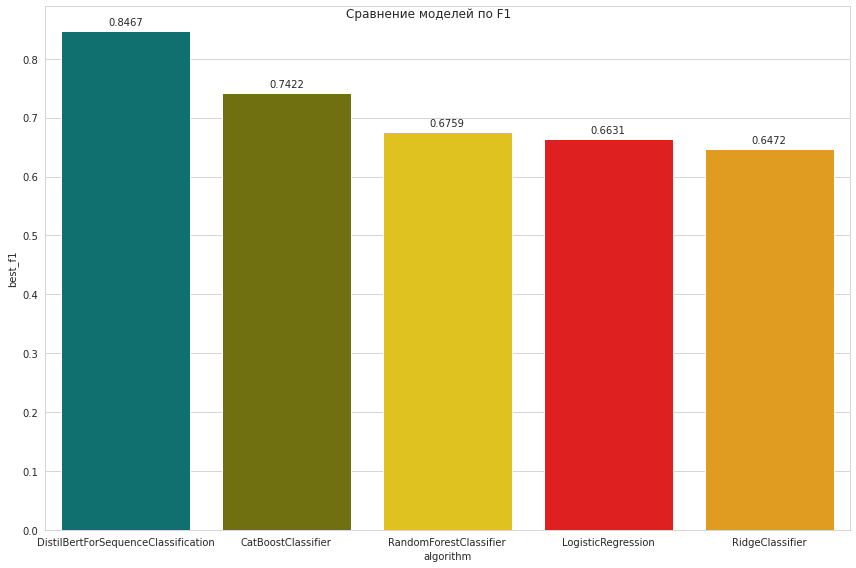

In [69]:
# вывод на экран значений целевой метрики обученных моделей в форме столбчатого графика
models_results.sort_values(by='best_f1', ascending=False, inplace=True)
    
fig, ax = plt.subplots(figsize=(12, 8))
    
sns.barplot(data=models_results,
            x='algorithm',
            y='best_f1',
            palette=models_palette)
    
for bar in ax.patches:
  ax.annotate(format(bar.get_height(), '.4f'), 
              (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
              ha='center', 
              va='center', 
              xytext=(0, 9), 
              textcoords='offset points')

fig.suptitle('Сравнение моделей по F1')
    
plt.tight_layout()
plt.show()

Мы видим, что:
- наилучшее  значение *F1* (0.8467) продемонстрировала модель *DistilBertForSequenceClassification* (при этом стоит отметить, что при обучении данной модели не использовалась кросс-валидация, так что ее результаты на тестовой выборке могут быть хуже);
- средние значения *F1* остальных моделей не соответствуют требованиям заказчика; 
- среднее занчение *F1* модели *CatBoostClassifier* (0.7422) позволяет сделать предположение, что в случае повторной оптимизации гиперпараметров метрики модели могут достигнуть целевого показателя 0.75.

### Анализ результатов лучшей модели

Проанализируем результаты лучшей модели. Для этого изучим ее матрицу ошибок на валидационной выборке:

In [70]:
# получение предсказаний лучшей модели на валидационной выборке
best_model_val_output = trainer.predict(ds_val)
best_model_val_preds = np.argmax(best_model_val_output.predictions, axis=-1)

***** Running Prediction *****
  Num examples = 31859
  Batch size = 16


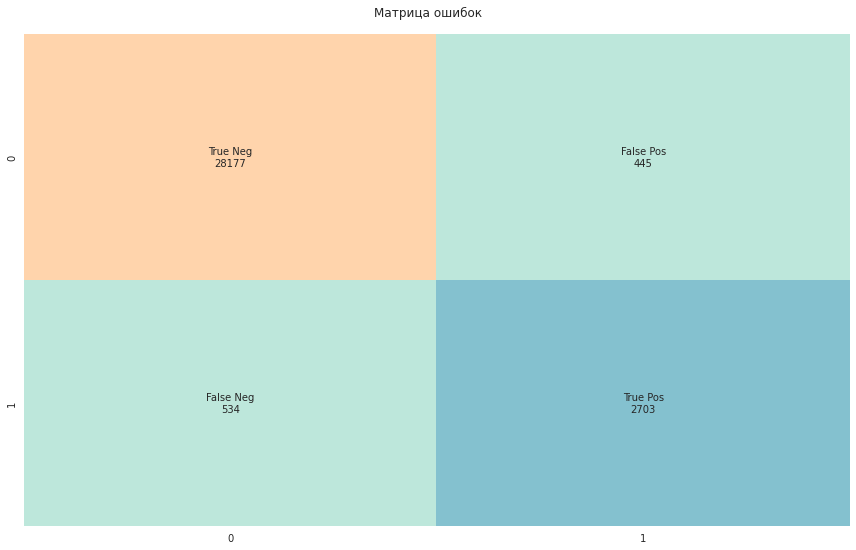

In [71]:
# построение и вывод на экран матрицы ошибок
conf_matrix = confusion_matrix(ds_val['label'], best_model_val_preds)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='icefire', cbar=False)

fig.suptitle('Матрица ошибок')
  
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Мы видим, что:
- количество ложных положительных и ложных отрицательных предсказаний модели примерно равны;
- лучшая модель корректно классифицировала ~84% токсичных комментариев.

### Выводы

По итогам анализа моделей мы пришли к следующим выводам:

- наилучшее  значение *F1* (0.8467) продемонстрировала модель *DistilBertForSequenceClassification* (при этом стоит отметить, что при обучении данной модели не использовалась кросс-валидация, так что ее результаты на тестовой выборке могут быть хуже);
- средние значения *F1* остальных моделей не соответствуют требованиям заказчика; 
- среднее занчение *F1* модели *CatBoostClassifier* (0.7422) позволяет сделать предположение, что в случае повторной оптимизации гиперпараметров метрики модели могут достигнуть целевого показателя 0.75;
- количество ложных положительных и ложных отрицательных предсказаний модели примерно равны;
- лучшая модель корректно классифицировала ~84% токсичных комментариев.

На следующем этапе протестируем лучшую модель.

## Выбор и тестирование лучшей модели

Исходя из критериев заказчика мы выбрали *DistilBertForSequenceClassification* (вторую версию) в качестве лучшей модели: данная модель показала наилучшее (среди моделей на основе других алгоритмов) среднее значение *F1* (0.8467).

In [72]:
# сохранение лучшей модели в переменную best_model
best_model = trainer

Протестируем лучшую модель на тестовой выборке:

In [73]:
# получение предсказаний лучшей модели на тестовой выборке
best_model_test_output = best_model.predict(ds_test)
best_model_test_preds = np.argmax(best_model_test_output.predictions, axis=-1)

***** Running Prediction *****
  Num examples = 31859
  Batch size = 16


In [74]:
# расчет и вывод на экран F1 лучшей модели на тестовой выборке
best_model_f1_test = f1_score(ds_test['label'], best_model_test_preds)

print('F1 лучшей модели на тестовой выборке:', best_model_f1_test)

F1 лучшей модели на тестовой выборке: 0.8527472527472527


Мы видим, что лучшая модель продемонстрировала на тестовой выборке значение *F1* 0.8527, что незначительно лучше ее значения на валидационной выборке.

Сравним полученное значение с целевым показателем метрики:

In [75]:
# сохранение цели по метрике качества в отдельную переменную
f1_target = 0.75

# расчет и вывод на экран количества процентов, на которые F1 лучшей модели выше
# целевого F1
best_model_vs_target = (best_model_f1_test - f1_target) / f1_target

print('На тестовой выборке F1 лучшей модели на', 
      '{:.2%}'.format(best_model_vs_target), 
      'выше целевого F1.')

На тестовой выборке F1 лучшей модели на 13.70% выше целевого F1.


Также сравним полученное значение с показателем константной модели, которая классифицирует все комментарии как токсичные:

In [76]:
# получение предсказаний константной модели на тестовой выборке
dummy_model_test_preds  = [1 for i in ds_test['label']]

# расчет и вывод на экран F1 константной модели на тестовой выборке
dummy_model_f1_test = f1_score(ds_test['label'], dummy_model_test_preds)

print('F1 константной модели на тестовой выборке:', dummy_model_f1_test)

F1 константной модели на тестовой выборке: 0.18446546614998857


In [77]:
# расчет и вывод на экран количества процентов, на которые F1 лучшей модели
# на тестовой выборке выше F1 константной модели
best_model_vs_dummy = (best_model_f1_test - dummy_model_f1_test) / dummy_model_f1_test

print('На тестовой выборке F1 лучшей модели на', 
      '{:.2%}'.format(best_model_vs_dummy), 
      'выше F1 константной модели.')

На тестовой выборке F1 лучшей модели на 362.28% выше F1 константной модели.


### Выводы

На данном этапе мы:
- исходя из критериев заказчика мы выбрали *DistilBertForSequenceClassification* (вторую версию) в качестве лучшей модели: данная модель показала наилучшее (среди моделей на основе других алгоритмов) среднее значение *F1* (0.8467);
- рассчитали *F1* лучшей модели на тестовой выборке и сравнили его с таргетом по качеству и показателем константной модели.

Лучшая модель продемонстрировала на тестовой выборке значение *F1* 0.8527, что:
- незначительно лучше ее значения на валидационной выборке;
- на ~14% лучше таргета по качеству (0.75); и
- на ~362% лучше *F1* константной модели.

## Общие выводы

В ходе работы мы построили модель классификации тональности комментариев для нового сервиса интернет-магазина «Викишоп».

Наша работа включала пять этапов:

1. загузка и изучение данных;
2. подготовка к обучению;
3. обучение моделей;
4. анализ моделей; и
5. выбор и тестирование лучшей модели.

**1. Загрузка и изучение данных**

По результатам изучения данных мы пришли к следующим выводам:

- в датасете 159 292 объекта;
- один объект содержит информацию об одном комментарии;
- по каждому объекту доступно 3 признака; помимо признаков *text* и *toxic*, указанных в описании к данным, также есть количественный признак *Unnamed: 0* (который возник при сохранении датасета и не является информативным для нашей работы);
- язык комментариев - английский;
- в токсичных комментариях используются обсценная лексика и восклицательные знаки;
- предоставленные данные несбалансированы: токсичные комментарии составляют ~10%; поскольку мы решаем задачу классификации, данное обстоятельство необходимо учитывать при обучении моделей;
- в датасете нет пропусков и явных дубликатов.

**2. Подготовка к обучению**

В ходе подготовки к обучению мы:

- удалили неинформативный столбец *Unnamed: 0*;
- переименовали столбец *toxic* в соответствии с требованиями моделей *BERT*, которые мы планируем использовать в дальнейшем;
- разделили данные на обучающие, валидационную и тестовую выборки в пропорции 3:1:1;
- конвертировали выборки в объекты класса Dataset (для дальнейшего использования инструментов *Hugging Face*);
- токенизирировали комментарии при помощи предобученного токенизатора *DistilBertTokenizerFast*;
- провели подготовку к обучению *DistilBertForSequenceClassification*:
  - создали объект класса *DefaultDataCollator* (для передачи модели данных батчами); и
  - создали функцию *compute_metrics* (для рассчета метрик *accuracy*, *f1*, *precision* и *recall*);
- создали признаки-эмбеддинги и целевой признак для не-*BERT* моделей;
- создали функции для оптимизации обучения не-*BERT* моделей:
  - *add_to_comparison* (для сохранения параметров и метрик модели в сравнительную таблицу); и
  - *run_random_search* (для проведения подбора гиперпараметров при помощи *RandomizedSearchCV*).

**3. Обучение моделей**

На данном этапе мы обучили 5 моделей: *LogisticRegression*, *RidgeClassifier*, *RandomForestClassifier*, *CatBoostClassifier* и *DistilBertForSequenceClassification*.

В рамках обучения мы:
- для первых четырех моделей (за исключением *LogisticRegression*) оптимизировали значения гиперпараметров, чтобы получить лучшее среднее значение *F1* (используя кросс-валидацию);
- для последней модели - переобучили модель на обучающей выборке с проверкой результатов на валидационной выборке.

**4. Анализ моделей**

По итогам анализа моделей мы пришли к следующим выводам:

- наилучшее  значение *F1* (0.8467) продемонстрировала модель *DistilBertForSequenceClassification* (при этом стоит отметить, что при обучении данной модели не использовалась кросс-валидация, так что ее результаты на тестовой выборке могут быть хуже);
- средние значения *F1* остальных моделей не соответствуют требованиям заказчика; 
- среднее занчение *F1* модели *CatBoostClassifier* (0.7422) позволяет сделать предположение, что в случае повторной оптимизации гиперпараметров метрики модели могут достигнуть целевого показателя 0.75;
- количество ложных положительных и ложных отрицательных предсказаний модели примерно равны;
- лучшая модель корректно классифицировала ~84% токсичных комментариев.

**5. Выбор и тестирование лучшей модели**

На данном этапе мы:
- исходя из критериев заказчика мы выбрали *DistilBertForSequenceClassification* (вторую версию) в качестве лучшей модели: данная модель показала наилучшее (среди моделей на основе других алгоритмов) среднее значение *F1* (0.8467);
- рассчитали *F1* лучшей модели на тестовой выборке и сравнили его с таргетом по качеству и показателем константной модели.

Лучшая модель продемонстрировала на тестовой выборке значение *F1* 0.8527, что:
- незначительно лучше ее значения на валидационной выборке;
- на ~14% лучше таргета по качеству (0.75); и
- на ~362% лучше *F1* константной модели.